In [1]:
pwd

'/home/dmarx/projects/whats-in-a-name'

In [1]:
with open('chatgpt_names.cleaned.txt') as f:
    names = f.read().split('\n')
print(len(names))

1433


In [2]:
first_names = list(set([name.split()[0].lower() for name in names if '.' not in name]))
first_names.sort()
len(first_names)

1081

In [85]:
first_names[:10]

['aamir',
 'aarif',
 'aaron',
 'abby',
 'abdullah',
 'abhay',
 'abhishek',
 'abigail',
 'adam',
 'adil']

In [87]:
last_names = list(set([name.split()[-1].lower() for name in names if '.' not in name]))
last_names.sort()
len(last_names)

1235

In [3]:
from pathlib import Path
from diffusers import StableDiffusionPipeline
import torch
import diffusers
import time
import torch
import matplotlib.pyplot as plt
import PIL
import numpy as np
import gc
from copy import deepcopy
from collections import Counter
import gc
from scipy.spatial.distance import pdist

In [25]:
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
                model_id,
                revision="fp16",
                #torch_dtype=torch.float16,
                #use_auth_token=True
            ).to('cuda')

# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0/blob/main/scheduler/scheduler_config.json
true, false, null = True, False, None
pipe.scheduler = diffusers.EulerDiscreteScheduler(
    **{
      "beta_end": 0.012,
      "beta_schedule": "scaled_linear",
      "beta_start": 0.00085,
      "interpolation_type": "linear",
      "num_train_timesteps": 1000,
      "prediction_type": "epsilon",
      "steps_offset": 1,
      "timestep_spacing": "leading",
      "trained_betas": null,
      "use_karras_sigmas": false
    }
)

# disable safety checker

#pipe.requires_safety_checker=False
def passthrough(images, *args, **kargs):
    return images, [False for _ in images]
pipe.safety_checker = passthrough

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/dmarx/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [26]:
root = Path("images-gpt-diversity")
#root = Path("images-gpt-diversity_firstnames")

In [ ]:
# RUN THIS CELL TO GENERATE IMAGES


mode = "full names"

if mode == "full names":
    root = Path("images-gpt-diversity")
    gen = enumerate(names)
elif mode == "first names":
    root = Path("images-gpt-diversity_firstnames")
    gen = enumerate(first_names)
    

    
#images_per_prompt = 24 #40
#images_per_prompt = 64
# fuck it.
images_per_name = 24 # 12
    

    
if 'clip_model' in locals():
    del clip_model
    gc.collect()
    torch.cuda.empty_cache()

kwargs = dict(
    num_inference_steps=35, #25,
    num_images_per_prompt= 12, # 16 # oh nice, i just assumed that would OOM # 8
    negative_prompt="b&w photography, collage, crowded",
)

skip_these_names = ['mark rothko']


for i, name in gen:
    if name in skip_these_names:
        continue
    print((i,name))
    prompt = f"a photo of {name}, portrait photography, full color, face full frame"
    prompt = prompt.lower().strip()
    
    outdir = root / name
    outdir.mkdir(parents=True, exist_ok=True)
    # TODO: add a jsonl metadata listing image fpaths and prompts
    while len(list(outdir.glob('*.png'))) < images_per_name:
        outv = pipe(prompt, **kwargs)
        for idx,im in enumerate(outv.images):
            # would prefer to name images by seed, but hf is makes it hard.
            fname = outdir / f"{int(time.time())}_{idx}.png" 
            im.save(fname)


(0, 'Kerli')
(1, 'Mark Rothko')


  0%|          | 0/35 [00:00<?, ?it/s]

(2, 'Arvydas Sabonis')


  0%|          | 0/35 [00:00<?, ?it/s]

(3, 'A. R. Rahman')


  0%|          | 0/35 [00:00<?, ?it/s]

(4, 'A.B. de Villiers')


  0%|          | 0/35 [00:00<?, ?it/s]

(5, 'Aamir Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(6, 'Aarif Rahman')


  0%|          | 0/35 [00:00<?, ?it/s]

(7, 'Aaron Carter')


  0%|          | 0/35 [00:00<?, ?it/s]

(8, 'Aaron Kwok')


  0%|          | 0/35 [00:00<?, ?it/s]

(9, 'Abby Wambach')


  0%|          | 0/35 [00:00<?, ?it/s]

(10, 'Abdullah Al Rowaished')


  0%|          | 0/35 [00:00<?, ?it/s]

(11, 'Abhay Deol')


  0%|          | 0/35 [00:00<?, ?it/s]

(12, 'Abhishek Bachchan')


  0%|          | 0/35 [00:00<?, ?it/s]

(13, 'Abigail Breslin')


  0%|          | 0/35 [00:00<?, ?it/s]

(14, 'Adam Beach')


  0%|          | 0/35 [00:00<?, ?it/s]

(15, 'Adil Hussain')


  0%|          | 0/35 [00:00<?, ?it/s]

(16, 'Aditi Rao Hydari')


  0%|          | 0/35 [00:00<?, ?it/s]

(17, 'Adriana Lima')


  0%|          | 0/35 [00:00<?, ?it/s]

(18, 'Adrien Brody')


  0%|          | 0/35 [00:00<?, ?it/s]

(19, 'Adrián Uribe')


  0%|          | 0/35 [00:00<?, ?it/s]

(20, 'Agnes Monica')


  0%|          | 0/35 [00:00<?, ?it/s]

(21, 'Ahmed Helmy')


  0%|          | 0/35 [00:00<?, ?it/s]

(22, 'Aidana Medenova')


  0%|          | 0/35 [00:00<?, ?it/s]

(23, 'Aikyn')


  0%|          | 0/35 [00:00<?, ?it/s]

(24, 'Aishwarya Rai')


  0%|          | 0/35 [00:00<?, ?it/s]

(25, 'Aishwarya Rai Bachchan')


  0%|          | 0/35 [00:00<?, ?it/s]

(26, 'Ajay Devgn')


  0%|          | 0/35 [00:00<?, ?it/s]

(27, 'Ajith Kumar')


  0%|          | 0/35 [00:00<?, ?it/s]

(28, 'Akhil Akkineni')


  0%|          | 0/35 [00:00<?, ?it/s]

(29, 'Akira')


  0%|          | 0/35 [00:00<?, ?it/s]

(30, 'Akkineni Nagarjuna')


  0%|          | 0/35 [00:00<?, ?it/s]

(31, 'Akshay Kumar')


  0%|          | 0/35 [00:00<?, ?it/s]

(32, 'Al Pacino')


  0%|          | 0/35 [00:00<?, ?it/s]

(33, 'Alamgir')


  0%|          | 0/35 [00:00<?, ?it/s]

(34, 'Alan Yang')


  0%|          | 0/35 [00:00<?, ?it/s]

(35, 'Alec Baldwin')


  0%|          | 0/35 [00:00<?, ?it/s]

(36, 'Alejandro Fernández')


  0%|          | 0/35 [00:00<?, ?it/s]

(37, 'Alex Morgan')


  0%|          | 0/35 [00:00<?, ?it/s]

(38, 'Alex Rendell')


  0%|          | 0/35 [00:00<?, ?it/s]

(39, 'Alexandria Ocasio-Cortez')


  0%|          | 0/35 [00:00<?, ?it/s]

(40, 'Alexis Sanchez')


  0%|          | 0/35 [00:00<?, ?it/s]

(41, 'Ali Fazal')


  0%|          | 0/35 [00:00<?, ?it/s]

(42, 'Ali Jee')


  0%|          | 0/35 [00:00<?, ?it/s]

(43, 'Ali Sethi')


  0%|          | 0/35 [00:00<?, ?it/s]

(44, 'Ali Suliman')


  0%|          | 0/35 [00:00<?, ?it/s]

(45, 'Ali Wong')


  0%|          | 0/35 [00:00<?, ?it/s]

(46, 'Ali Zafar')


  0%|          | 0/35 [00:00<?, ?it/s]

(47, 'Alia Bhatt')


  0%|          | 0/35 [00:00<?, ?it/s]

(48, 'Alicia Vikander')


  0%|          | 0/35 [00:00<?, ?it/s]

(49, 'Alina Zagitova')


  0%|          | 0/35 [00:00<?, ?it/s]

(50, 'Alisher Uzoqov')


  0%|          | 0/35 [00:00<?, ?it/s]

(51, 'Alison Hinds')


  0%|          | 0/35 [00:00<?, ?it/s]

(52, 'Allu Arjun')


  0%|          | 0/35 [00:00<?, ?it/s]

(53, 'Allyson Felix')


  0%|          | 0/35 [00:00<?, ?it/s]

(54, 'Aly Raisman')


  0%|          | 0/35 [00:00<?, ?it/s]

(55, 'Alyona Lanskaya')


  0%|          | 0/35 [00:00<?, ?it/s]

(56, 'Alyssa Naeher')


  0%|          | 0/35 [00:00<?, ?it/s]

(57, 'Amala Paul')


  0%|          | 0/35 [00:00<?, ?it/s]

(58, 'Amanda Seyfried')


  0%|          | 0/35 [00:00<?, ?it/s]

(59, 'Amber Liu')


  0%|          | 0/35 [00:00<?, ?it/s]

(60, 'America Ferrera')


  0%|          | 0/35 [00:00<?, ?it/s]

(61, 'Amit Sadh')


  0%|          | 0/35 [00:00<?, ?it/s]

(62, 'Amitabh Bachchan')


  0%|          | 0/35 [00:00<?, ?it/s]

(63, 'Amr Waked')


  0%|          | 0/35 [00:00<?, ?it/s]

(64, 'Amrita Rao')


  0%|          | 0/35 [00:00<?, ?it/s]

(65, 'Amy Adams')


  0%|          | 0/35 [00:00<?, ?it/s]

(66, 'Amy Jackson')


  0%|          | 0/35 [00:00<?, ?it/s]

(67, 'Amy Poehler')


  0%|          | 0/35 [00:00<?, ?it/s]

(68, 'Amyra Dastur')


  0%|          | 0/35 [00:00<?, ?it/s]

(69, 'Ana Ivanović')


  0%|          | 0/35 [00:00<?, ?it/s]

(70, 'Ananya Panday')


  0%|          | 0/35 [00:00<?, ?it/s]

(71, 'Andre Agassi')


  0%|          | 0/35 [00:00<?, ?it/s]

(72, 'Andy Lau')


  0%|          | 0/35 [00:00<?, ?it/s]

(73, 'Andy Serkis')


  0%|          | 0/35 [00:00<?, ?it/s]

(74, 'Angela Bassett')


  0%|          | 0/35 [00:00<?, ?it/s]

(75, 'Angela Chang')


  0%|          | 0/35 [00:00<?, ?it/s]

(76, 'AngelaBaby (Yang Ying)')


  0%|          | 0/35 [00:00<?, ?it/s]

(77, 'Angelina Jolie')


  0%|          | 0/35 [00:00<?, ?it/s]

(78, 'Angelique Boyer')


  0%|          | 0/35 [00:00<?, ?it/s]

(79, 'Anil Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(80, 'Anirudh Ravichander')


  0%|          | 0/35 [00:00<?, ?it/s]

(81, 'Anita Mui')


  0%|          | 0/35 [00:00<?, ?it/s]

(82, 'Anita Yuen')


  0%|          | 0/35 [00:00<?, ?it/s]

(83, 'Ann Kok')


  0%|          | 0/35 [00:00<?, ?it/s]

(84, 'Anna Chlumsky')


  0%|          | 0/35 [00:00<?, ?it/s]

(85, 'Anna Kournikova')


  0%|          | 0/35 [00:00<?, ?it/s]

(86, 'Anna Paquin')


  0%|          | 0/35 [00:00<?, ?it/s]

(87, 'Anna Popplewell')


  0%|          | 0/35 [00:00<?, ?it/s]

(88, 'Anne Curtis')


  0%|          | 0/35 [00:00<?, ?it/s]

(109, 'Asghar Farhadi')


  0%|          | 0/35 [00:00<?, ?it/s]

(110, 'Asif Ali')


  0%|          | 0/35 [00:00<?, ?it/s]

(111, 'Asin')


  0%|          | 0/35 [00:00<?, ?it/s]

(112, 'Asin Thottumkal')


  0%|          | 0/35 [00:00<?, ?it/s]

(113, 'Assi El Helani')


  0%|          | 0/35 [00:00<?, ?it/s]

(114, 'Atharvaa')


  0%|          | 0/35 [00:00<?, ?it/s]

(115, 'Atif Aslam')


  0%|          | 0/35 [00:00<?, ?it/s]

(116, 'Atiqa Odho')


  0%|          | 0/35 [00:00<?, ?it/s]

(117, "Auli'i Cravalho")


  0%|          | 0/35 [00:00<?, ?it/s]

(118, 'Ava DuVernay')


  0%|          | 0/35 [00:00<?, ?it/s]

(119, 'Awkwafina')


  0%|          | 0/35 [00:00<?, ?it/s]

(120, 'Awkwafina (Nora Lum)')


  0%|          | 0/35 [00:00<?, ?it/s]

(121, 'Ayah Bdeir')


  0%|          | 0/35 [00:00<?, ?it/s]

(122, 'Ayase Haruka')


  0%|          | 0/35 [00:00<?, ?it/s]

(123, 'Ayesha Dharker')


  0%|          | 0/35 [00:00<?, ?it/s]

(124, 'Ayesha Takia')


  0%|          | 0/35 [00:00<?, ?it/s]

(125, 'Ayim Mukhamedjanova')


  0%|          | 0/35 [00:00<?, ?it/s]

(126, 'Ayumi Hamasaki')


  0%|          | 0/35 [00:00<?, ?it/s]

(127, 'Ayushmann Khurrana')


  0%|          | 0/35 [00:00<?, ?it/s]

(128, 'Aziz Ansari')


  0%|          | 0/35 [00:00<?, ?it/s]

(129, 'Babe Didrikson Zaharias')


  0%|          | 0/35 [00:00<?, ?it/s]

(130, 'Bae Doona')


  0%|          | 0/35 [00:00<?, ?it/s]

(131, 'Bae Suzy')


  0%|          | 0/35 [00:00<?, ?it/s]

(132, 'Bae Yong-joon')


  0%|          | 0/35 [00:00<?, ?it/s]

(133, 'Barun Sobti')


  0%|          | 0/35 [00:00<?, ?it/s]

(313, 'Donnie Yen')


  0%|          | 0/35 [00:00<?, ?it/s]

(314, 'Donny Osmond')


  0%|          | 0/35 [00:00<?, ?it/s]

(315, 'Dorothy Hamill')


  0%|          | 0/35 [00:00<?, ?it/s]

(316, 'Drew Barrymore')


  0%|          | 0/35 [00:00<?, ?it/s]

(317, 'Dulquer Salmaan')


  0%|          | 0/35 [00:00<?, ?it/s]

(318, 'Dustin Hoffman')


  0%|          | 0/35 [00:00<?, ?it/s]

(319, 'Dwayne Johnson')


  0%|          | 0/35 [00:00<?, ?it/s]

(320, 'Eddie Peng')


  0%|          | 0/35 [00:00<?, ?it/s]

(321, 'Eddie Redmayne')


  0%|          | 0/35 [00:00<?, ?it/s]

(322, 'Eden Hazard')


  0%|          | 0/35 [00:00<?, ?it/s]

(323, 'Edi Gathegi')


  0%|          | 0/35 [00:00<?, ?it/s]

(324, 'Eduardo Yáñez')


  0%|          | 0/35 [00:00<?, ?it/s]

(325, 'Edward James Olmos')


  0%|          | 0/35 [00:00<?, ?it/s]

(326, 'Edward Norton')


  0%|          | 0/35 [00:00<?, ?it/s]

(327, 'Edward Yang')


  0%|          | 0/35 [00:00<?, ?it/s]

(328, 'Edwin Moses')


  0%|          | 0/35 [00:00<?, ?it/s]

(329, 'Ekin Cheng')


  0%|          | 0/35 [00:00<?, ?it/s]

(330, 'Eli Manning')


  0%|          | 0/35 [00:00<?, ?it/s]

(331, 'Elijah Wood')


  0%|          | 0/35 [00:00<?, ?it/s]

(332, 'Elisabeth Moss')


  0%|          | 0/35 [00:00<?, ?it/s]

(333, 'Elissa')


  0%|          | 0/35 [00:00<?, ?it/s]

(334, 'Elizabeth Olsen')


  0%|          | 0/35 [00:00<?, ?it/s]

(335, 'Elizabeth Taylor')


  0%|          | 0/35 [00:00<?, ?it/s]

(336, 'Ella Aminuddin')


  0%|          | 0/35 [00:00<?, ?it/s]

(337, 'Ella Chen')


  0%|          | 0/35 [00:00<?, ?it/s]

(338, 'Elle Fanning')


  0%|          | 0/35 [00:00<?, ?it/s]

(339, 'Ellen Burstyn')


  0%|          | 0/35 [00:00<?, ?it/s]

(340, 'Ellyse Perry')


  0%|          | 0/35 [00:00<?, ?it/s]

(341, 'Elodie Yung')


  0%|          | 0/35 [00:00<?, ?it/s]

(342, 'Elçin Sangu')


  0%|          | 0/35 [00:00<?, ?it/s]

(343, 'Emilia Clarke')


  0%|          | 0/35 [00:00<?, ?it/s]

(344, 'Emilio Estefan')


  0%|          | 0/35 [00:00<?, ?it/s]

(345, 'Emma Stone')


  0%|          | 0/35 [00:00<?, ?it/s]

(346, 'Emma Thompson')


  0%|          | 0/35 [00:00<?, ?it/s]

(347, 'Emma Watson')


  0%|          | 0/35 [00:00<?, ?it/s]

(348, 'Eric Wainaina')


  0%|          | 0/35 [00:00<?, ?it/s]

(349, 'Erke Esmahan')


  0%|          | 0/35 [00:00<?, ?it/s]

(350, 'Eros Ramazzotti')


  0%|          | 0/35 [00:00<?, ?it/s]

(351, 'Esai Morales')


  0%|          | 0/35 [00:00<?, ?it/s]

(352, 'Esha Deol')


  0%|          | 0/35 [00:00<?, ?it/s]

(353, 'Esperanza Spalding')


  0%|          | 0/35 [00:00<?, ?it/s]

(354, 'Ethan Hawke')


  0%|          | 0/35 [00:00<?, ?it/s]

(355, 'Eugene')


  0%|          | 0/35 [00:00<?, ?it/s]

(356, 'Kim Yoo-jin')


  0%|          | 0/35 [00:00<?, ?it/s]

(357, 'Eugenia Suárez')


  0%|          | 0/35 [00:00<?, ?it/s]

(358, 'Eugenio Derbez')


  0%|          | 0/35 [00:00<?, ?it/s]

(359, 'Eva Huang')


  0%|          | 0/35 [00:00<?, ?it/s]

(360, 'Eva Longoria')


  0%|          | 0/35 [00:00<?, ?it/s]

(361, 'Eva Mendes')


  0%|          | 0/35 [00:00<?, ?it/s]

(362, 'Evgenia Medvedeva')


  0%|          | 0/35 [00:00<?, ?it/s]

(363, 'Ewan McGregor')


  0%|          | 0/35 [00:00<?, ?it/s]

(364, 'Fahad Mustafa')


  0%|          | 0/35 [00:00<?, ?it/s]

(365, 'Fahadh Faasil')


  0%|          | 0/35 [00:00<?, ?it/s]

(366, 'Fairuz')


  0%|          | 0/35 [00:00<?, ?it/s]

(367, 'Fan Bingbing')


  0%|          | 0/35 [00:00<?, ?it/s]

(368, 'Fann Wong')


  0%|          | 0/35 [00:00<?, ?it/s]

(369, 'Farhan Akhtar')


  0%|          | 0/35 [00:00<?, ?it/s]

(370, 'Farid Al-Attrash')


  0%|          | 0/35 [00:00<?, ?it/s]

(371, 'Fawad Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(372, 'Faye Dunaway')


  0%|          | 0/35 [00:00<?, ?it/s]

(373, 'Faye Wong')


  0%|          | 0/35 [00:00<?, ?it/s]

(374, 'Ferenc Puskás')


  0%|          | 0/35 [00:00<?, ?it/s]

(375, 'Fernanda Castillo')


  0%|          | 0/35 [00:00<?, ?it/s]

(376, 'Fernanda Montenegro')


  0%|          | 0/35 [00:00<?, ?it/s]

(377, 'Fernando Colunga')


  0%|          | 0/35 [00:00<?, ?it/s]

(378, 'Fernando Valenzuela')


  0%|          | 0/35 [00:00<?, ?it/s]

(379, 'Feroze Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(380, 'Fiona May')


  0%|          | 0/35 [00:00<?, ?it/s]

(381, 'Florence Griffith Joyner')


  0%|          | 0/35 [00:00<?, ?it/s]

(382, 'Floyd Mayweather Jr.')


  0%|          | 0/35 [00:00<?, ?it/s]

(383, 'Forest Whitaker')


  0%|          | 0/35 [00:00<?, ?it/s]

(384, 'Frances McDormand')


  0%|          | 0/35 [00:00<?, ?it/s]

(385, 'Frank Lampard')


  0%|          | 0/35 [00:00<?, ?it/s]

(386, 'Frankie Muniz')


  0%|          | 0/35 [00:00<?, ?it/s]

(387, 'Franz Beckenbauer')


  0%|          | 0/35 [00:00<?, ?it/s]

(388, 'Fred Savage')


  0%|          | 0/35 [00:00<?, ?it/s]

(389, 'Freddy Adu')


  0%|          | 0/35 [00:00<?, ?it/s]

(390, 'Freida Pinto')


  0%|          | 0/35 [00:00<?, ?it/s]

(391, 'Frida Kahlo')


  0%|          | 0/35 [00:00<?, ?it/s]

(392, 'Funke Akindele')


  0%|          | 0/35 [00:00<?, ?it/s]

(393, 'Gabby Douglas')


  0%|          | 0/35 [00:00<?, ?it/s]

(394, 'Gabourey Sidibe')


  0%|          | 0/35 [00:00<?, ?it/s]

(395, 'Gabrielle Douglas')


  0%|          | 0/35 [00:00<?, ?it/s]

(396, 'Gaby Hoffmann')


  0%|          | 0/35 [00:00<?, ?it/s]

(397, 'Gael García Bernal')


  0%|          | 0/35 [00:00<?, ?it/s]

(398, 'Gal Gadot')


  0%|          | 0/35 [00:00<?, ?it/s]

(399, 'Gary Chaw')


  0%|          | 0/35 [00:00<?, ?it/s]

(400, 'Gary Coleman')


  0%|          | 0/35 [00:00<?, ?it/s]

(401, 'Gary Oldman')


  0%|          | 0/35 [00:00<?, ?it/s]

(402, 'Gauhar Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(403, 'Gautham Karthik')


  0%|          | 0/35 [00:00<?, ?it/s]

(404, 'Geeta Phogat')


  0%|          | 0/35 [00:00<?, ?it/s]

(405, "Genelia D'Souza")


  0%|          | 0/35 [00:00<?, ?it/s]

(406, 'Genevieve Nnaji')


  0%|          | 0/35 [00:00<?, ?it/s]

(407, 'Geoffrey Rush')


  0%|          | 0/35 [00:00<?, ?it/s]

(408, 'George Best')


  0%|          | 0/35 [00:00<?, ?it/s]

(409, 'George Clooney')


  0%|          | 0/35 [00:00<?, ?it/s]

(410, 'George Takei')


  0%|          | 0/35 [00:00<?, ?it/s]

(411, 'Gerard Butler')


  0%|          | 0/35 [00:00<?, ?it/s]

(412, 'Gerard Piqué')


  0%|          | 0/35 [00:00<?, ?it/s]

(413, 'Gian Marco Zignago')


  0%|          | 0/35 [00:00<?, ?it/s]

(414, 'Gillian Anderson')


  0%|          | 0/35 [00:00<?, ?it/s]

(415, 'Gina Rodriguez')


  0%|          | 0/35 [00:00<?, ?it/s]

(416, 'Gina Torres')


  0%|          | 0/35 [00:00<?, ?it/s]

(417, 'Girish Kulkarni')


  0%|          | 0/35 [00:00<?, ?it/s]

(418, 'Gisele Bündchen')


  0%|          | 0/35 [00:00<?, ?it/s]

(419, 'Glenda Jackson')


  0%|          | 0/35 [00:00<?, ?it/s]

(420, 'Glenn Close')


  0%|          | 0/35 [00:00<?, ?it/s]

(421, 'Goldie Hawn')


  0%|          | 0/35 [00:00<?, ?it/s]

(422, 'Gong Hyo-jin')


  0%|          | 0/35 [00:00<?, ?it/s]

(423, 'Gong Li')


  0%|          | 0/35 [00:00<?, ?it/s]

(424, 'Gong Min-ji (Minzy)')


  0%|          | 0/35 [00:00<?, ?it/s]

(425, 'Gong Yoo')


  0%|          | 0/35 [00:00<?, ?it/s]

(426, 'Goran Višnjić')


  0%|          | 0/35 [00:00<?, ?it/s]

(427, 'Grace Jones')


  0%|          | 0/35 [00:00<?, ?it/s]

(428, 'Graham Greene')


  0%|          | 0/35 [00:00<?, ?it/s]

(429, 'Gugu Mbatha-Raw')


  0%|          | 0/35 [00:00<?, ?it/s]

(430, 'Guillermo del Toro')


  0%|          | 0/35 [00:00<?, ?it/s]

(431, 'Gulsim Ali')


  0%|          | 0/35 [00:00<?, ?it/s]

(432, 'Gulzhigit Kalykov')


  0%|          | 0/35 [00:00<?, ?it/s]

(433, 'Guo Jingjing')


  0%|          | 0/35 [00:00<?, ?it/s]

(434, 'Gustavo Cerati')


  0%|          | 0/35 [00:00<?, ?it/s]

(435, 'Gwyneth Paltrow')


  0%|          | 0/35 [00:00<?, ?it/s]

(436, 'H.E.R.')


  0%|          | 0/35 [00:00<?, ?it/s]

(437, 'Gabriella Sarmiento Wilson')


  0%|          | 0/35 [00:00<?, ?it/s]

(438, 'Ha Dong Hoon')


  0%|          | 0/35 [00:00<?, ?it/s]

(439, 'Ha Ji-won')


  0%|          | 0/35 [00:00<?, ?it/s]

(440, 'Ha Ji-won')
(441, 'Jeon Hae-rim')


  0%|          | 0/35 [00:00<?, ?it/s]

(442, 'Hadia Ghaleb')


  0%|          | 0/35 [00:00<?, ?it/s]

(443, 'Haifa Wehbe')


  0%|          | 0/35 [00:00<?, ?it/s]

(444, 'Haile Gebrselassie')


  0%|          | 0/35 [00:00<?, ?it/s]

(445, 'Hakeem Olajuwon')


  0%|          | 0/35 [00:00<?, ?it/s]

(446, 'Haley Bennett')


  0%|          | 0/35 [00:00<?, ?it/s]

(447, 'Haley Joel Osment')


  0%|          | 0/35 [00:00<?, ?it/s]

(448, 'Halle Berry')


  0%|          | 0/35 [00:00<?, ?it/s]

(449, 'Han Chae-young')


  0%|          | 0/35 [00:00<?, ?it/s]

(450, 'Han Ga-in')


  0%|          | 0/35 [00:00<?, ?it/s]

(451, 'Han Hyo-joo')


  0%|          | 0/35 [00:00<?, ?it/s]

(452, 'Hana Mae Lee')


  0%|          | 0/35 [00:00<?, ?it/s]

(453, 'Hani Mitwasi')


  0%|          | 0/35 [00:00<?, ?it/s]

(454, 'Hanis Zalikha')


  0%|          | 0/35 [00:00<?, ?it/s]

(455, 'Hansika Motwani')


  0%|          | 0/35 [00:00<?, ?it/s]

(456, 'Harrison Ford')


  0%|          | 0/35 [00:00<?, ?it/s]

(457, 'Harry Kane')


  0%|          | 0/35 [00:00<?, ?it/s]

(458, 'Haruki Murakami')


  0%|          | 0/35 [00:00<?, ?it/s]

(459, 'Haruma Miura')


  0%|          | 0/35 [00:00<?, ?it/s]

(460, 'Hasan Minhaj')


  0%|          | 0/35 [00:00<?, ?it/s]

(461, 'Hassan El Shafei')


  0%|          | 0/35 [00:00<?, ?it/s]

(462, 'Hayao Miyazaki')


  0%|          | 0/35 [00:00<?, ?it/s]

(463, 'Heather Headley')


  0%|          | 0/35 [00:00<?, ?it/s]

(464, 'Helen Hunt')


  0%|          | 0/35 [00:00<?, ?it/s]

(465, 'Helen Mirren')


  0%|          | 0/35 [00:00<?, ?it/s]

(466, 'Hema Malini')


  0%|          | 0/35 [00:00<?, ?it/s]

(467, 'Henry Lau')


  0%|          | 0/35 [00:00<?, ?it/s]

(468, 'Henry Thomas')


  0%|          | 0/35 [00:00<?, ?it/s]

(469, 'Hicham El Guerrouj')


  0%|          | 0/35 [00:00<?, ?it/s]

(470, 'Hideaki Anno')


  0%|          | 0/35 [00:00<?, ?it/s]

(471, 'Hikaru Utada')


  0%|          | 0/35 [00:00<?, ?it/s]

(472, 'Hilary Duff')


  0%|          | 0/35 [00:00<?, ?it/s]

(473, 'Hilary Swank')


  0%|          | 0/35 [00:00<?, ?it/s]

(474, 'Hima Das')


  0%|          | 0/35 [00:00<?, ?it/s]

(475, 'Hina Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(476, 'Hiroomi Tosaka')


  0%|          | 0/35 [00:00<?, ?it/s]

(477, 'Hiroyuki Sanada')


  0%|          | 0/35 [00:00<?, ?it/s]

(478, 'Holly Hunter')


  0%|          | 0/35 [00:00<?, ?it/s]

(479, 'Hope Solo')


  0%|          | 0/35 [00:00<?, ?it/s]

(480, 'Hrithik Roshan')


  0%|          | 0/35 [00:00<?, ?it/s]

(481, 'Hu Ge')


  0%|          | 0/35 [00:00<?, ?it/s]

(482, 'Huang Bo')


  0%|          | 0/35 [00:00<?, ?it/s]

(483, 'Huang Shengyi')


  0%|          | 0/35 [00:00<?, ?it/s]

(484, 'Huang Xiaoming')


  0%|          | 0/35 [00:00<?, ?it/s]

(485, 'Huang Yi')


  0%|          | 0/35 [00:00<?, ?it/s]

(486, 'Huang Zitao')


  0%|          | 0/35 [00:00<?, ?it/s]

(487, 'Hugh Jackman')


  0%|          | 0/35 [00:00<?, ?it/s]

(488, 'Huma Qureshi')


  0%|          | 0/35 [00:00<?, ?it/s]

(489, 'Hyun Bin')


  0%|          | 0/35 [00:00<?, ?it/s]

(490, 'HyunA')


  0%|          | 0/35 [00:00<?, ?it/s]

(491, 'Kim Hyun-ah')


  0%|          | 0/35 [00:00<?, ?it/s]

(492, 'Lee Ji-eun')


  0%|          | 0/35 [00:00<?, ?it/s]

(493, 'Ian McKellen')


  0%|          | 0/35 [00:00<?, ?it/s]

(494, 'Ian Somerhalder')


  0%|          | 0/35 [00:00<?, ?it/s]

(495, 'Ichiro Suzuki')


  0%|          | 0/35 [00:00<?, ?it/s]

(496, 'Idris Elba')


  0%|          | 0/35 [00:00<?, ?it/s]

(497, 'Iko Uwais')


  0%|          | 0/35 [00:00<?, ?it/s]

(498, "Ileana D'Cruz")


  0%|          | 0/35 [00:00<?, ?it/s]

(499, 'Imran Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(500, 'Iqbaal Dhiafakhri Ramadhan')


  0%|          | 0/35 [00:00<?, ?it/s]

(501, 'Irrfan Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(502, 'Isabel Allende')


  0%|          | 0/35 [00:00<?, ?it/s]

(503, 'Isabelle Huppert')


  0%|          | 0/35 [00:00<?, ?it/s]

(504, 'Isabelle Kaif')


  0%|          | 0/35 [00:00<?, ?it/s]

(505, 'Isha Talwar')


  0%|          | 0/35 [00:00<?, ?it/s]

(506, 'Issa Rae')


  0%|          | 0/35 [00:00<?, ?it/s]

(507, 'Isyana Sarasvati')


  0%|          | 0/35 [00:00<?, ?it/s]

(508, 'Iva Lamkum')


  0%|          | 0/35 [00:00<?, ?it/s]

(509, 'Iwa Moto')


  0%|          | 0/35 [00:00<?, ?it/s]

(510, 'Izara Aishah')


  0%|          | 0/35 [00:00<?, ?it/s]

(511, 'Jackie Chan')


  0%|          | 0/35 [00:00<?, ?it/s]

(512, 'Jackie Joyner-Kersee')


  0%|          | 0/35 [00:00<?, ?it/s]

(513, 'Jacob Vargas')


  0%|          | 0/35 [00:00<?, ?it/s]

(514, 'Jacqueline Fernandez')


  0%|          | 0/35 [00:00<?, ?it/s]

(515, 'Jaden Smith')


  0%|          | 0/35 [00:00<?, ?it/s]

(516, 'Jaime Camil')


  0%|          | 0/35 [00:00<?, ?it/s]

(517, 'Jake Gyllenhaal')


  0%|          | 0/35 [00:00<?, ?it/s]

(518, 'Jam Hsiao')


  0%|          | 0/35 [00:00<?, ?it/s]

(519, 'Jamala')


  0%|          | 0/35 [00:00<?, ?it/s]

(520, 'James Earl Jones')


  0%|          | 0/35 [00:00<?, ?it/s]

(521, 'James Franco')


  0%|          | 0/35 [00:00<?, ?it/s]

(522, 'Jamie Foxx')


  0%|          | 0/35 [00:00<?, ?it/s]

(523, 'Jamie Lee Curtis')


  0%|          | 0/35 [00:00<?, ?it/s]

(524, 'Jamie Lynn Spears')


  0%|          | 0/35 [00:00<?, ?it/s]

(525, 'Jana Burčeska')


  0%|          | 0/35 [00:00<?, ?it/s]

(526, 'Janel Parrish')


  0%|          | 0/35 [00:00<?, ?it/s]

(527, 'Janelle Monáe')


  0%|          | 0/35 [00:00<?, ?it/s]

(528, 'Jang Dong-gun')


  0%|          | 0/35 [00:00<?, ?it/s]

(529, 'Janhvi Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(530, 'Jason Bateman')


  0%|          | 0/35 [00:00<?, ?it/s]

(531, 'Jason Momoa')


  0%|          | 0/35 [00:00<?, ?it/s]

(532, 'Javed Sheikh')


  0%|          | 0/35 [00:00<?, ?it/s]

(533, 'Javier Bardem')


  0%|          | 0/35 [00:00<?, ?it/s]

(534, 'Jay Chou')


  0%|          | 0/35 [00:00<?, ?it/s]

(535, 'Jay Park')


  0%|          | 0/35 [00:00<?, ?it/s]

(536, 'Jayasurya')


  0%|          | 0/35 [00:00<?, ?it/s]

(537, 'Jeff Bridges')


  0%|          | 0/35 [00:00<?, ?it/s]

(538, 'Jefri Nichol')


  0%|          | 0/35 [00:00<?, ?it/s]

(539, 'Jemaine Clement')


  0%|          | 0/35 [00:00<?, ?it/s]

(540, 'Jemal Saparowa')


  0%|          | 0/35 [00:00<?, ?it/s]

(541, 'Jennie Finch')


  0%|          | 0/35 [00:00<?, ?it/s]

(542, 'Jennifer Aniston')


  0%|          | 0/35 [00:00<?, ?it/s]

(543, 'Jennifer Connelly')


  0%|          | 0/35 [00:00<?, ?it/s]

(544, 'Jennifer Hudson')


  0%|          | 0/35 [00:00<?, ?it/s]

(545, 'Jennifer Lawrence')


  0%|          | 0/35 [00:00<?, ?it/s]

(546, 'Jeon Do-yeon')


  0%|          | 0/35 [00:00<?, ?it/s]

(547, 'Jeon Ji-hyun')


  0%|          | 0/35 [00:00<?, ?it/s]

(548, 'Jeremy Irons')


  0%|          | 0/35 [00:00<?, ?it/s]

(549, 'Jermaine Leef')


  0%|          | 0/35 [00:00<?, ?it/s]

(550, 'Jerrold Tarog')


  0%|          | 0/35 [00:00<?, ?it/s]

(551, 'Jessica Alba')


  0%|          | 0/35 [00:00<?, ?it/s]

(552, 'Jessica Chastain')


  0%|          | 0/35 [00:00<?, ?it/s]

(553, 'Jessica Ennis-Hill')


  0%|          | 0/35 [00:00<?, ?it/s]

(554, 'Jessica Lange')


  0%|          | 0/35 [00:00<?, ?it/s]

(555, 'Jessica Mauboy')


  0%|          | 0/35 [00:00<?, ?it/s]

(556, 'Jessy Mendiola')


  0%|          | 0/35 [00:00<?, ?it/s]

(557, 'Jet Li')


  0%|          | 0/35 [00:00<?, ?it/s]

(558, 'Jhumpa Lahiri')


  0%|          | 0/35 [00:00<?, ?it/s]

(559, 'Ji Chang-wook')


  0%|          | 0/35 [00:00<?, ?it/s]

(560, 'Jim Carrey')


  0%|          | 0/35 [00:00<?, ?it/s]

(561, 'Jim Thorpe')


  0%|          | 0/35 [00:00<?, ?it/s]

(562, 'Jimmy O. Yang')


  0%|          | 0/35 [00:00<?, ?it/s]

(563, 'Jimmy Smits')


  0%|          | 0/35 [00:00<?, ?it/s]

(564, 'Jin (Kim Seok-jin)')


  0%|          | 0/35 [00:00<?, ?it/s]

(565, 'Jing Tian')


  0%|          | 0/35 [00:00<?, ?it/s]

(566, 'Jo In-sung')


  0%|          | 0/35 [00:00<?, ?it/s]

(567, 'Joaquin Phoenix')


  0%|          | 0/35 [00:00<?, ?it/s]

(568, 'Joaquín Guzmán')


  0%|          | 0/35 [00:00<?, ?it/s]

(569, 'Joaquín Sabina')


  0%|          | 0/35 [00:00<?, ?it/s]

(570, 'Jodie Foster')


  0%|          | 0/35 [00:00<?, ?it/s]

(571, 'Joe Odagiri')


  0%|          | 0/35 [00:00<?, ?it/s]

(572, 'Joe Taslim')


  0%|          | 0/35 [00:00<?, ?it/s]

(573, 'Joey Lawrence')


  0%|          | 0/35 [00:00<?, ?it/s]

(574, 'Joey Yung')


  0%|          | 0/35 [00:00<?, ?it/s]

(575, 'John Abraham')


  0%|          | 0/35 [00:00<?, ?it/s]

(576, 'John Cho')


  0%|          | 0/35 [00:00<?, ?it/s]

(577, 'John Dumelo')


  0%|          | 0/35 [00:00<?, ?it/s]

(578, 'John Legend')


  0%|          | 0/35 [00:00<?, ?it/s]

(579, 'John Leguizamo')


  0%|          | 0/35 [00:00<?, ?it/s]

(580, 'John Malkovich')


  0%|          | 0/35 [00:00<?, ?it/s]

(581, 'Johnny Depp')


  0%|          | 0/35 [00:00<?, ?it/s]

(582, 'Jolin Tsai')


  0%|          | 0/35 [00:00<?, ?it/s]

(583, 'Jon Hamm')


  0%|          | 0/35 [00:00<?, ?it/s]

(584, 'Jonas Brothers')


  0%|          | 0/35 [00:00<?, ?it/s]

(585, 'Jonathan Taylor Thomas')


  0%|          | 0/35 [00:00<?, ?it/s]

(586, 'Jordan Peele')


  0%|          | 0/35 [00:00<?, ?it/s]

(587, 'Jordan Rodrigues')


  0%|          | 0/35 [00:00<?, ?it/s]

(588, 'Jorge Negrete')


  0%|          | 0/35 [00:00<?, ?it/s]

(589, 'Jose Antonio Vargas')


  0%|          | 0/35 [00:00<?, ?it/s]

(590, 'Joseph Cheng')


  0%|          | 0/35 [00:00<?, ?it/s]

(591, 'Joseph Gordon-Levitt')


  0%|          | 0/35 [00:00<?, ?it/s]

(592, 'Joseph Vijay')


  0%|          | 0/35 [00:00<?, ?it/s]

(593, 'José Alfredo Jiménez')


  0%|          | 0/35 [00:00<?, ?it/s]

(594, 'José Ferrer')


  0%|          | 0/35 [00:00<?, ?it/s]

(595, 'José José')


  0%|          | 0/35 [00:00<?, ?it/s]

(596, 'Jr. NTR')


  0%|          | 0/35 [00:00<?, ?it/s]

(597, 'Juan Gabriel')


  0%|          | 0/35 [00:00<?, ?it/s]

(598, 'Juan Luis Guerra')


  0%|          | 0/35 [00:00<?, ?it/s]

(599, 'Juanes')


  0%|          | 0/35 [00:00<?, ?it/s]

(600, 'Jubin Nautiyal')


  0%|          | 0/35 [00:00<?, ?it/s]

(601, 'Judi Dench')


  0%|          | 0/35 [00:00<?, ?it/s]

(602, 'Judy Garland')


  0%|          | 0/35 [00:00<?, ?it/s]

(603, 'Julia Louis-Dreyfus')


  0%|          | 0/35 [00:00<?, ?it/s]

(604, 'Julia Roberts')


  0%|          | 0/35 [00:00<?, ?it/s]

(605, 'Julianne Moore')


  0%|          | 0/35 [00:00<?, ?it/s]

(606, 'Julie Estelle')


  0%|          | 0/35 [00:00<?, ?it/s]

(607, 'Juliette Binoche')


  0%|          | 0/35 [00:00<?, ?it/s]

(608, 'Jun Ji-hyun')


  0%|          | 0/35 [00:00<?, ?it/s]

(609, 'Jung Woo-sung')


  0%|          | 0/35 [00:00<?, ?it/s]

(610, 'Jung Yun-ho')


  0%|          | 0/35 [00:00<?, ?it/s]

(611, 'U-Know Yunho')


  0%|          | 0/35 [00:00<?, ?it/s]

(612, 'Justin Bieber')


  0%|          | 0/35 [00:00<?, ?it/s]

(613, 'Justin Timberlake')


  0%|          | 0/35 [00:00<?, ?it/s]

(614, 'Jyothika')


  0%|          | 0/35 [00:00<?, ?it/s]

(615, 'KJ Apa')


  0%|          | 0/35 [00:00<?, ?it/s]

(616, 'Kairat Nurtas')


  0%|          | 0/35 [00:00<?, ?it/s]

(617, 'Kajal Aggarwal')


  0%|          | 0/35 [00:00<?, ?it/s]

(618, 'Kajol')


  0%|          | 0/35 [00:00<?, ?it/s]

(619, 'Kaká')


  0%|          | 0/35 [00:00<?, ?it/s]

(620, 'Kal Penn')


  0%|          | 0/35 [00:00<?, ?it/s]

(621, 'Kaliopi')


  0%|          | 0/35 [00:00<?, ?it/s]

(622, 'Kamal Haasan')


  0%|          | 0/35 [00:00<?, ?it/s]

(623, 'Kang Ha-neul')


  0%|          | 0/35 [00:00<?, ?it/s]

(624, 'Kang So-ra')


  0%|          | 0/35 [00:00<?, ?it/s]

(625, 'Kangana Ranaut')


  0%|          | 0/35 [00:00<?, ?it/s]

(626, 'Kapil Dev')


  0%|          | 0/35 [00:00<?, ?it/s]

(627, 'Kareem Abdul-Jabbar')


  0%|          | 0/35 [00:00<?, ?it/s]

(628, 'Kareena Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(629, 'Kareena Kapoor Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(630, 'Karen Mok')


  0%|          | 0/35 [00:00<?, ?it/s]

(631, 'Karisma Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(632, 'Karl Malone')


  0%|          | 0/35 [00:00<?, ?it/s]

(633, 'Karolina Gočeva')


  0%|          | 0/35 [00:00<?, ?it/s]

(634, 'Karthi')


  0%|          | 0/35 [00:00<?, ?it/s]

(635, 'Karthik Sivakumar')


  0%|          | 0/35 [00:00<?, ?it/s]

(636, 'Karthi')
(637, 'Kartik Aaryan')


  0%|          | 0/35 [00:00<?, ?it/s]

(638, 'Katarina Johnson-Thompson')


  0%|          | 0/35 [00:00<?, ?it/s]

(639, 'Kate Beckinsale')


  0%|          | 0/35 [00:00<?, ?it/s]

(640, 'Kate Blanchett')


  0%|          | 0/35 [00:00<?, ?it/s]

(641, 'Kate Hudson')


  0%|          | 0/35 [00:00<?, ?it/s]

(642, 'Kate Winslet')


  0%|          | 0/35 [00:00<?, ?it/s]

(643, 'Kathem Al-Saher')


  0%|          | 0/35 [00:00<?, ?it/s]

(644, 'Kathy Bates')


  0%|          | 0/35 [00:00<?, ?it/s]

(645, 'Kathy Griffin')


  0%|          | 0/35 [00:00<?, ?it/s]

(646, 'Katie Holmes')


  0%|          | 0/35 [00:00<?, ?it/s]

(647, 'Katie Ledecky')


  0%|          | 0/35 [00:00<?, ?it/s]

(648, 'Katrina Kaif')


  0%|          | 0/35 [00:00<?, ?it/s]

(649, 'Keanu Reeves')


  0%|          | 0/35 [00:00<?, ?it/s]

(650, 'Kei Nishikori')


  0%|          | 0/35 [00:00<?, ?it/s]

(651, 'Keira Knightley')


  0%|          | 0/35 [00:00<?, ?it/s]

(652, 'Keisha Castle-Hughes')


  0%|          | 0/35 [00:00<?, ?it/s]

(653, 'Kelly Chen')


  0%|          | 0/35 [00:00<?, ?it/s]

(654, 'Ken Chu')


  0%|          | 0/35 [00:00<?, ?it/s]

(655, 'Ken Jeong')


  0%|          | 0/35 [00:00<?, ?it/s]

(656, 'Ken Watanabe')


  0%|          | 0/35 [00:00<?, ?it/s]

(657, 'Kendrick Lamar')


  0%|          | 0/35 [00:00<?, ?it/s]

(658, 'Kenenisa Bekele')


  0%|          | 0/35 [00:00<?, ?it/s]

(659, 'Kento Yamazaki')


  0%|          | 0/35 [00:00<?, ?it/s]

(660, 'Kerri Strug')


  0%|          | 0/35 [00:00<?, ?it/s]

(661, 'Kerry Washington')


  0%|          | 0/35 [00:00<?, ?it/s]

(662, 'Kevin Bacon')


  0%|          | 0/35 [00:00<?, ?it/s]

(663, 'Kevin Costner')


  0%|          | 0/35 [00:00<?, ?it/s]

(664, 'Kevin Hart')


  0%|          | 0/35 [00:00<?, ?it/s]

(665, 'Kevin Spacey')


  0%|          | 0/35 [00:00<?, ?it/s]

(666, 'Khalil Fong')


  0%|          | 0/35 [00:00<?, ?it/s]

(667, 'Kiara Advani')


  0%|          | 0/35 [00:00<?, ?it/s]

(668, 'Kim Go-eun')


  0%|          | 0/35 [00:00<?, ?it/s]

(669, 'Kim Hyo-yeon')


  0%|          | 0/35 [00:00<?, ?it/s]

(670, 'Kim Soo-hyun')


  0%|          | 0/35 [00:00<?, ?it/s]

(671, 'Kim Tae-hee')


  0%|          | 0/35 [00:00<?, ?it/s]

(672, 'Kim Tae-ri')


  0%|          | 0/35 [00:00<?, ?it/s]

(673, 'Kim Woo-bin')


  0%|          | 0/35 [00:00<?, ?it/s]

(674, 'King Kapisi')


  0%|          | 0/35 [00:00<?, ?it/s]

(675, 'Kipchoge Keino')


  0%|          | 0/35 [00:00<?, ?it/s]

(676, 'Kirsten Dunst')


  0%|          | 0/35 [00:00<?, ?it/s]

(677, 'Kishore Kumar')


  0%|          | 0/35 [00:00<?, ?it/s]

(678, 'Ko Chen-tung')


  0%|          | 0/35 [00:00<?, ?it/s]

(679, 'Ko Chen-tung')
(680, 'Kai Ko')


  0%|          | 0/35 [00:00<?, ?it/s]

(681, 'Ko Gyung-pyo')


  0%|          | 0/35 [00:00<?, ?it/s]

(682, 'Ko So-young')


  0%|          | 0/35 [00:00<?, ?it/s]

(683, 'Kobe Bryant')


  0%|          | 0/35 [00:00<?, ?it/s]

(684, 'Komal Aziz Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(685, 'Komal Jha')


  0%|          | 0/35 [00:00<?, ?it/s]

(686, 'Konkona Sen Sharma')


  0%|          | 0/35 [00:00<?, ?it/s]

(687, 'Kristi Yamaguchi')


  0%|          | 0/35 [00:00<?, ?it/s]

(688, 'Kristofer Hivju')


  0%|          | 0/35 [00:00<?, ?it/s]

(689, 'Kriti Kharbanda')


  0%|          | 0/35 [00:00<?, ?it/s]

(690, 'Kriti Sanon')


  0%|          | 0/35 [00:00<?, ?it/s]

(691, 'Kubbra Sait')


  0%|          | 0/35 [00:00<?, ?it/s]

(692, 'Kumail Nanjiani')


  0%|          | 0/35 [00:00<?, ?it/s]

(693, 'Kunal Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(694, 'Kunal Khemu')


  0%|          | 0/35 [00:00<?, ?it/s]

(695, 'Kunal Nayyar')


  0%|          | 0/35 [00:00<?, ?it/s]

(696, 'Kurt Russell')


  0%|          | 0/35 [00:00<?, ?it/s]

(697, 'Kwon Sang-woo')


  0%|          | 0/35 [00:00<?, ?it/s]

(698, 'Kıvanç Tatlıtuğ')


  0%|          | 0/35 [00:00<?, ?it/s]

(699, 'Lady Gaga')


  0%|          | 0/35 [00:00<?, ?it/s]

(700, 'Laima Vaikule')


  0%|          | 0/35 [00:00<?, ?it/s]

(701, 'Lakshmi Menon')


  0%|          | 0/35 [00:00<?, ?it/s]

(702, 'Lana Condor')


  0%|          | 0/35 [00:00<?, ?it/s]

(703, 'Landon Donovan')


  0%|          | 0/35 [00:00<?, ?it/s]

(704, 'Lapi Mariner')


  0%|          | 0/35 [00:00<?, ?it/s]

(705, 'Larisa Latynina')


  0%|          | 0/35 [00:00<?, ?it/s]

(706, 'Larry Bird')


  0%|          | 0/35 [00:00<?, ?it/s]

(707, 'Lata Mangeshkar')


  0%|          | 0/35 [00:00<?, ?it/s]

(708, 'Laura Dern')


  0%|          | 0/35 [00:00<?, ?it/s]

(709, 'Lauren Gottlieb')


  0%|          | 0/35 [00:00<?, ?it/s]

(710, 'Laurence Fishburne')


  0%|          | 0/35 [00:00<?, ?it/s]

(711, 'Laurie Hernandez')


  0%|          | 0/35 [00:00<?, ?it/s]

(712, 'Lavanya Tripathi')


  0%|          | 0/35 [00:00<?, ?it/s]

(713, 'Lawrence Wong')


  0%|          | 0/35 [00:00<?, ?it/s]

(714, 'LeBron James')


  0%|          | 0/35 [00:00<?, ?it/s]

(715, 'Lea Michele')


  0%|          | 0/35 [00:00<?, ?it/s]

(716, 'Leah Dizon')


  0%|          | 0/35 [00:00<?, ?it/s]

(717, 'Lee Byung-hun')


  0%|          | 0/35 [00:00<?, ?it/s]

(718, 'Lee Chong Wei')


  0%|          | 0/35 [00:00<?, ?it/s]

(719, 'Lee Hyori')


  0%|          | 0/35 [00:00<?, ?it/s]

(720, 'Lee Jong-suk')


  0%|          | 0/35 [00:00<?, ?it/s]

(721, 'Lee Joon-gi')


  0%|          | 0/35 [00:00<?, ?it/s]

(722, 'Lee Min-ho')


  0%|          | 0/35 [00:00<?, ?it/s]

(723, 'Lee Seung-gi')


  0%|          | 0/35 [00:00<?, ?it/s]

(724, 'Lee Young-ae')


  0%|          | 0/35 [00:00<?, ?it/s]

(725, 'Leila Hatami')


  0%|          | 0/35 [00:00<?, ?it/s]

(726, 'Lena Dunham')


  0%|          | 0/35 [00:00<?, ?it/s]

(727, 'Leonardo DiCaprio')


  0%|          | 0/35 [00:00<?, ?it/s]

(728, 'Letitia Wright')


  0%|          | 0/35 [00:00<?, ?it/s]

(729, 'Liam Hemsworth')


  0%|          | 0/35 [00:00<?, ?it/s]

(730, 'Liam Neeson')


  0%|          | 0/35 [00:00<?, ?it/s]

(731, 'Lil Rick')


  0%|          | 0/35 [00:00<?, ?it/s]

(732, 'Lin Chi-ling')


  0%|          | 0/35 [00:00<?, ?it/s]

(733, 'Linda Chung')


  0%|          | 0/35 [00:00<?, ?it/s]

(734, 'Lindsay Lohan')


  0%|          | 0/35 [00:00<?, ?it/s]

(755, 'Lucy Liu')


  0%|          | 0/35 [00:00<?, ?it/s]

(756, 'Luis Fonsi')


  0%|          | 0/35 [00:00<?, ?it/s]

(757, 'Luis Miguel')


  0%|          | 0/35 [00:00<?, ?it/s]

(758, 'Luis Suárez')


  0%|          | 0/35 [00:00<?, ?it/s]

(759, 'Luka Modrić')


  0%|          | 0/35 [00:00<?, ?it/s]

(760, 'Luna Maya')


  0%|          | 0/35 [00:00<?, ?it/s]

(761, "Lupita Nyong'o")


  0%|          | 0/35 [00:00<?, ?it/s]

(762, 'Lupita Tovar')


  0%|          | 0/35 [00:00<?, ?it/s]

(763, 'Léa Seydoux')


  0%|          | 0/35 [00:00<?, ?it/s]

(764, 'M.I.A.')


  0%|          | 0/35 [00:00<?, ?it/s]

(765, 'Maya Arulpragasam')


  0%|          | 0/35 [00:00<?, ?it/s]

(766, 'Mathangi Arulpragasam')


  0%|          | 0/35 [00:00<?, ?it/s]

(767, 'Macaulay Culkin')


  0%|          | 0/35 [00:00<?, ?it/s]

(768, 'Macauley Culkin')


  0%|          | 0/35 [00:00<?, ?it/s]

(769, 'Madhavan')


  0%|          | 0/35 [00:00<?, ?it/s]

(770, 'Madhubala')


  0%|          | 0/35 [00:00<?, ?it/s]

(771, 'Madhuri Dixit')


  0%|          | 0/35 [00:00<?, ?it/s]

(772, 'Madina Saduakasova')


  0%|          | 0/35 [00:00<?, ?it/s]

(773, 'Magaly Medina')


  0%|          | 0/35 [00:00<?, ?it/s]

(774, 'Maggie Cheung')


  0%|          | 0/35 [00:00<?, ?it/s]

(775, 'Maggie Q')


  0%|          | 0/35 [00:00<?, ?it/s]

(776, 'Magic Johnson')


  0%|          | 0/35 [00:00<?, ?it/s]

(777, 'Mahendra Singh Dhoni')


  0%|          | 0/35 [00:00<?, ?it/s]

(778, 'Mahershala Ali')


  0%|          | 0/35 [00:00<?, ?it/s]

(779, 'Mahesh Babu')


  0%|          | 0/35 [00:00<?, ?it/s]

(780, 'Mahira Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(781, 'Malaika Arora')


  0%|          | 0/35 [00:00<?, ?it/s]

(782, 'Malala Yousafzai')


  0%|          | 0/35 [00:00<?, ?it/s]

(783, 'Mammootty')


  0%|          | 0/35 [00:00<?, ?it/s]

(784, 'Mamta Kulkarni')


  0%|          | 0/35 [00:00<?, ?it/s]

(785, 'Mamta Mohandas')


  0%|          | 0/35 [00:00<?, ?it/s]

(786, 'Manish Dayal')


  0%|          | 0/35 [00:00<?, ?it/s]

(787, 'Manisha Koirala')


  0%|          | 0/35 [00:00<?, ?it/s]

(788, 'Manizha')


  0%|          | 0/35 [00:00<?, ?it/s]

(789, 'Manny Pacquiao')


  0%|          | 0/35 [00:00<?, ?it/s]

(790, 'Manoj Bajpayee')


  0%|          | 0/35 [00:00<?, ?it/s]

(791, 'Manolo Cardona')


  0%|          | 0/35 [00:00<?, ?it/s]

(792, 'Manuel Neuer')


  0%|          | 0/35 [00:00<?, ?it/s]

(793, 'Mara Wilson')


  0%|          | 0/35 [00:00<?, ?it/s]

(794, 'Marcel Hirscher')


  0%|          | 0/35 [00:00<?, ?it/s]

(795, 'Margot Robbie')


  0%|          | 0/35 [00:00<?, ?it/s]

(796, 'Maria Mutola')


  0%|          | 0/35 [00:00<?, ?it/s]

(797, 'Maria Sharapova')


  0%|          | 0/35 [00:00<?, ?it/s]

(798, 'Maria Toorpakai Wazir')


  0%|          | 0/35 [00:00<?, ?it/s]

(799, 'Maria Vasilevich')


  0%|          | 0/35 [00:00<?, ?it/s]

(800, 'Marilyn Monroe')


  0%|          | 0/35 [00:00<?, ?it/s]

(801, 'Marina Nill')


  0%|          | 0/35 [00:00<?, ?it/s]

(802, 'Mario Moreno "Cantinflas"')


  0%|          | 0/35 [00:00<?, ?it/s]

(803, 'Mario Testino')


  0%|          | 0/35 [00:00<?, ?it/s]

(804, 'Mario Van Peebles')


  0%|          | 0/35 [00:00<?, ?it/s]

(805, 'Marion Cotillard')


  0%|          | 0/35 [00:00<?, ?it/s]

(806, 'Marit Bjørgen')


  0%|          | 0/35 [00:00<?, ?it/s]

(807, 'Mark Ruffalo')


  0%|          | 0/35 [00:00<?, ?it/s]

(808, 'Mark Zuckerberg')


  0%|          | 0/35 [00:00<?, ?it/s]

(809, 'Mark-Paul Gosselaar')


  0%|          | 0/35 [00:00<?, ?it/s]

(810, 'Marsai Martin')


  0%|          | 0/35 [00:00<?, ?it/s]

(811, 'Marta')


  0%|          | 0/35 [00:00<?, ?it/s]

(812, 'Martin Scorsese')


  0%|          | 0/35 [00:00<?, ?it/s]

(813, 'Martina Hingis')


  0%|          | 0/35 [00:00<?, ?it/s]

(814, 'Martina Stoessel')


  0%|          | 0/35 [00:00<?, ?it/s]

(815, 'Mary Kom')


  0%|          | 0/35 [00:00<?, ?it/s]

(816, 'Mary Lou Retton')


  0%|          | 0/35 [00:00<?, ?it/s]

(817, 'Mary-Kate and Ashley Olsen')


  0%|          | 0/35 [00:00<?, ?it/s]

(818, 'Maryam Mirzakhani')


  0%|          | 0/35 [00:00<?, ?it/s]

(819, 'Masaharu Fukuyama')


  0%|          | 0/35 [00:00<?, ?it/s]

(820, 'Masaki Suda')


  0%|          | 0/35 [00:00<?, ?it/s]

(821, 'Masami Kurumada')


  0%|          | 0/35 [00:00<?, ?it/s]

(822, 'Matamba')


  0%|          | 0/35 [00:00<?, ?it/s]

(823, 'Matt Damon')


  0%|          | 0/35 [00:00<?, ?it/s]

(824, 'Matthew McConaughey')


  0%|          | 0/35 [00:00<?, ?it/s]

(825, 'Maudy Ayunda')


  0%|          | 0/35 [00:00<?, ?it/s]

(826, 'Maudy Koesnaedi')


  0%|          | 0/35 [00:00<?, ?it/s]

(827, 'Maureen Connolly')


  0%|          | 0/35 [00:00<?, ?it/s]

(828, 'Max Korzh')


  0%|          | 0/35 [00:00<?, ?it/s]

(829, 'Maya Diab')


  0%|          | 0/35 [00:00<?, ?it/s]

(830, 'Maya Moore')


  0%|          | 0/35 [00:00<?, ?it/s]

(831, 'Meera')


  0%|          | 0/35 [00:00<?, ?it/s]

(832, 'Meera Jasmine')


  0%|          | 0/35 [00:00<?, ?it/s]

(833, 'Meg Ryan')


  0%|          | 0/35 [00:00<?, ?it/s]

(834, 'Meisa Kuroki')


  0%|          | 0/35 [00:00<?, ?it/s]

(835, 'Mel Gibson')


  0%|          | 0/35 [00:00<?, ?it/s]

(836, 'Melissa Gilbert')


  0%|          | 0/35 [00:00<?, ?it/s]

(837, 'Mercy Johnson')


  0%|          | 0/35 [00:00<?, ?it/s]

(838, 'Merle Dandridge')


  0%|          | 0/35 [00:00<?, ?it/s]

(839, 'Meryl Streep')


  0%|          | 0/35 [00:00<?, ?it/s]

(840, 'Messi')


  0%|          | 0/35 [00:00<?, ?it/s]

(841, 'Mesut Özil')


  0%|          | 0/35 [00:00<?, ?it/s]

(842, 'Mia Hamm')


  0%|          | 0/35 [00:00<?, ?it/s]

(843, 'Michael Caine')


  0%|          | 0/35 [00:00<?, ?it/s]

(844, 'Michael Douglas')


  0%|          | 0/35 [00:00<?, ?it/s]

(845, 'Michael Fassbender')


  0%|          | 0/35 [00:00<?, ?it/s]

(846, 'Michael J. Fox')


  0%|          | 0/35 [00:00<?, ?it/s]

(847, 'Michael Jackson')


  0%|          | 0/35 [00:00<?, ?it/s]

(848, 'Michael Jordan')


  0%|          | 0/35 [00:00<?, ?it/s]

(849, 'Michael Keaton')


  0%|          | 0/35 [00:00<?, ?it/s]

(850, 'Michael Owen')


  0%|          | 0/35 [00:00<?, ?it/s]

(851, 'Michael Phelps')


  0%|          | 0/35 [00:00<?, ?it/s]

(852, 'Michelle Chong')


  0%|          | 0/35 [00:00<?, ?it/s]

(853, 'Michelle Kwan')


  0%|          | 0/35 [00:00<?, ?it/s]

(854, 'Michelle Pfeiffer')


  0%|          | 0/35 [00:00<?, ?it/s]

(855, 'Michelle Reis')


  0%|          | 0/35 [00:00<?, ?it/s]

(856, 'Michelle Rodriguez')


  0%|          | 0/35 [00:00<?, ?it/s]

(857, 'Michelle Wie')


  0%|          | 0/35 [00:00<?, ?it/s]

(858, 'Michelle Ye')


  0%|          | 0/35 [00:00<?, ?it/s]

(859, 'Michelle Yeoh')


  0%|          | 0/35 [00:00<?, ?it/s]

(860, 'Mickey Rooney')


  0%|          | 0/35 [00:00<?, ?it/s]

(861, 'Mickey Rourke')


  0%|          | 0/35 [00:00<?, ?it/s]

(862, 'Mihiro')


  0%|          | 0/35 [00:00<?, ?it/s]

(863, 'Mila Jovovic')


  0%|          | 0/35 [00:00<?, ?it/s]

(864, 'Mila Kunis')


  0%|          | 0/35 [00:00<?, ?it/s]

(865, 'Miley Cyrus')


  0%|          | 0/35 [00:00<?, ?it/s]

(866, 'Milla Jovovich')


  0%|          | 0/35 [00:00<?, ?it/s]

(867, 'Millie Bobby Brown')


  0%|          | 0/35 [00:00<?, ?it/s]

(868, 'Milton Cortez')


  0%|          | 0/35 [00:00<?, ?it/s]

(869, 'Mindy Kaling')


  0%|          | 0/35 [00:00<?, ?it/s]

(870, 'Vera Mindy Chokalingam')


  0%|          | 0/35 [00:00<?, ?it/s]

(871, 'Mira Filzah')


  0%|          | 0/35 [00:00<?, ?it/s]

(872, 'Mira Sethi')


  0%|          | 0/35 [00:00<?, ?it/s]

(873, 'Miranada Ayim')


  0%|          | 0/35 [00:00<?, ?it/s]

(874, 'Miranda Tapsell')


  0%|          | 0/35 [00:00<?, ?it/s]

(875, 'Miroslav Klose')


  0%|          | 0/35 [00:00<?, ?it/s]

(876, 'Misty Copeland')


  0%|          | 0/35 [00:00<?, ?it/s]

(877, 'Misty May-Treanor')


  0%|          | 0/35 [00:00<?, ?it/s]

(878, 'Mithun Chakraborty')


  0%|          | 0/35 [00:00<?, ?it/s]

(879, 'Mizuhara Kiko')


  0%|          | 0/35 [00:00<?, ?it/s]

(880, 'Mizushima Hiro')


  0%|          | 0/35 [00:00<?, ?it/s]

(881, 'Mohamed Salah')


  0%|          | 0/35 [00:00<?, ?it/s]

(882, 'Mohammed Rafi')


  0%|          | 0/35 [00:00<?, ?it/s]

(883, 'Mohammed Zeeshan Ayyub')


  0%|          | 0/35 [00:00<?, ?it/s]

(884, 'Mohanlal')


  0%|          | 0/35 [00:00<?, ?it/s]

(885, 'Mon Laferte')


  0%|          | 0/35 [00:00<?, ?it/s]

(886, 'Mona Zaki')


  0%|          | 0/35 [00:00<?, ?it/s]

(887, 'Monica Bellucci')


  0%|          | 0/35 [00:00<?, ?it/s]

(888, 'Monica Seles')


  0%|          | 0/35 [00:00<?, ?it/s]

(889, 'Moon Geun-young')


  0%|          | 0/35 [00:00<?, ?it/s]

(890, 'Morgan Freeman')


  0%|          | 0/35 [00:00<?, ?it/s]

(891, 'Moses Chan')


  0%|          | 0/35 [00:00<?, ?it/s]

(892, 'Mouni Roy')


  0%|          | 0/35 [00:00<?, ?it/s]

(893, 'Mrunal Thakur')


  0%|          | 0/35 [00:00<?, ?it/s]

(894, 'Muhammad Ali')


  0%|          | 0/35 [00:00<?, ?it/s]

(895, 'Mumtaz Sorcar')


  0%|          | 0/35 [00:00<?, ?it/s]

(896, 'Muna Fadil')


  0%|          | 0/35 [00:00<?, ?it/s]

(897, 'Mylene Dizon')


  0%|          | 0/35 [00:00<?, ?it/s]

(898, 'Myriam Hernández')


  0%|          | 0/35 [00:00<?, ?it/s]

(899, 'N. T. Rama Rao Jr.')


  0%|          | 0/35 [00:00<?, ?it/s]

(900, 'Nadia Comăneci')


  0%|          | 0/35 [00:00<?, ?it/s]

(901, 'Nadia Dajani')


  0%|          | 0/35 [00:00<?, ?it/s]

(902, 'Nadine Lustre')


  0%|          | 0/35 [00:00<?, ?it/s]

(903, 'Naga Chaitanya')


  0%|          | 0/35 [00:00<?, ?it/s]

(904, 'Namie Amuro')


  0%|          | 0/35 [00:00<?, ?it/s]

(905, 'Nana Mouskouri')


  0%|          | 0/35 [00:00<?, ?it/s]

(906, 'Nana Patekar')


  0%|          | 0/35 [00:00<?, ?it/s]

(907, 'Nancy Ajram')


  0%|          | 0/35 [00:00<?, ?it/s]

(908, 'Nancy Kerrigan')


  0%|          | 0/35 [00:00<?, ?it/s]

(909, 'Naomi Osaka')


  0%|          | 0/35 [00:00<?, ?it/s]

(910, 'Naomie Harris')


  0%|          | 0/35 [00:00<?, ?it/s]

(911, 'Naoto Takenaka')


  0%|          | 0/35 [00:00<?, ?it/s]

(912, 'Nargis Fakhri')


  0%|          | 0/35 [00:00<?, ?it/s]

(913, 'Naseeruddin Shah')


  0%|          | 0/35 [00:00<?, ?it/s]

(914, 'Nassar')


  0%|          | 0/35 [00:00<?, ?it/s]

(915, 'Nastia Liukin')


  0%|          | 0/35 [00:00<?, ?it/s]

(916, 'Natalie Dormer')


  0%|          | 0/35 [00:00<?, ?it/s]

(917, 'Natalie Portman')


  0%|          | 0/35 [00:00<?, ?it/s]

(918, 'Natalie Wood')


  0%|          | 0/35 [00:00<?, ?it/s]

(919, 'Natti Natasha')


  0%|          | 0/35 [00:00<?, ?it/s]

(920, 'Nav')


  0%|          | 0/35 [00:00<?, ?it/s]

(921, 'Naveen Andrews')


  0%|          | 0/35 [00:00<?, ?it/s]

(922, 'Nawal El Kuwaitia')


  0%|          | 0/35 [00:00<?, ?it/s]

(923, 'Nawazuddin Siddiqui')


  0%|          | 0/35 [00:00<?, ?it/s]

(924, 'Nayanthara')


  0%|          | 0/35 [00:00<?, ?it/s]

(925, 'Nazym Ospanova')


  0%|          | 0/35 [00:00<?, ?it/s]

(926, 'Neelam Kothari')


  0%|          | 0/35 [00:00<?, ?it/s]

(927, 'Neelofa')


  0%|          | 0/35 [00:00<?, ?it/s]

(928, 'Neha Sharma')


  0%|          | 0/35 [00:00<?, ?it/s]

(929, 'Neil Patrick Harris')


  0%|          | 0/35 [00:00<?, ?it/s]

(930, 'Neymar Jr.')


  0%|          | 0/35 [00:00<?, ?it/s]

(931, 'Nichkhun')


  0%|          | 0/35 [00:00<?, ?it/s]

(932, 'Nicholas Saputra')


  0%|          | 0/35 [00:00<?, ?it/s]

(933, 'Nicholas Tse')


  0%|          | 0/35 [00:00<?, ?it/s]

(934, 'Nicki Minaj')


  0%|          | 0/35 [00:00<?, ?it/s]

(935, 'Nicolas Cage')


  0%|          | 0/35 [00:00<?, ?it/s]

(936, 'Nicole Kidman')


  0%|          | 0/35 [00:00<?, ?it/s]

(937, 'Nicole Scherzinger')


  0%|          | 0/35 [00:00<?, ?it/s]

(938, 'Nikhil Advani')


  0%|          | 0/35 [00:00<?, ?it/s]

(939, 'Nikita Willy')


  0%|          | 0/35 [00:00<?, ?it/s]

(940, 'Nikki Galrani')


  0%|          | 0/35 [00:00<?, ?it/s]

(941, 'Nikki Gil')


  0%|          | 0/35 [00:00<?, ?it/s]

(942, 'Nina Dobrev')


  0%|          | 0/35 [00:00<?, ?it/s]

(943, 'Ning Jing')


  0%|          | 0/35 [00:00<?, ?it/s]

(944, 'Nithya Menen')


  0%|          | 0/35 [00:00<?, ?it/s]

(945, 'Niti Taylor')


  0%|          | 0/35 [00:00<?, ?it/s]

(946, 'Nivetha Thomas')


  0%|          | 0/35 [00:00<?, ?it/s]

(947, 'Nivin Pauly')


  0%|          | 0/35 [00:00<?, ?it/s]

(948, 'Nong Thon')


  0%|          | 0/35 [00:00<?, ?it/s]

(949, 'Nora Fatehi')


  0%|          | 0/35 [00:00<?, ?it/s]

(950, 'Noriko Sakai')


  0%|          | 0/35 [00:00<?, ?it/s]

(951, 'Novak Djokovic')


  0%|          | 0/35 [00:00<?, ?it/s]

(952, 'Noziya Karomatullo')


  0%|          | 0/35 [00:00<?, ?it/s]

(953, 'Nusrat Fateh Ali Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(954, 'Nutan')


  0%|          | 0/35 [00:00<?, ?it/s]

(955, 'Octavia Spencer')


  0%|          | 0/35 [00:00<?, ?it/s]

(956, 'Oka Antara')


  0%|          | 0/35 [00:00<?, ?it/s]

(957, 'Olamide')


  0%|          | 0/35 [00:00<?, ?it/s]

(958, 'Olga Korbut')


  0%|          | 0/35 [00:00<?, ?it/s]

(959, 'Olga Kurylenko')


  0%|          | 0/35 [00:00<?, ?it/s]

(960, 'Olivia Colman')


  0%|          | 0/35 [00:00<?, ?it/s]

(961, 'Omar Sharif')


  0%|          | 0/35 [00:00<?, ?it/s]

(962, 'Omar Sy')


  0%|          | 0/35 [00:00<?, ?it/s]

(963, 'Omotola Jalade Ekeinde')


  0%|          | 0/35 [00:00<?, ?it/s]

(964, 'Oprah Winfrey')


  0%|          | 0/35 [00:00<?, ?it/s]

(965, 'Osamu Tezuka')


  0%|          | 0/35 [00:00<?, ?it/s]

(966, 'Oscar De La Hoya')


  0%|          | 0/35 [00:00<?, ?it/s]

(967, 'Oscar Isaac')


  0%|          | 0/35 [00:00<?, ?it/s]

(968, 'Osric Chau')


  0%|          | 0/35 [00:00<?, ?it/s]

(969, 'Osvaldo Ardiles')


  0%|          | 0/35 [00:00<?, ?it/s]

(970, 'Owen Wilson')


  0%|          | 0/35 [00:00<?, ?it/s]

(971, 'Pamela Anderson')


  0%|          | 0/35 [00:00<?, ?it/s]

(972, 'Pankaj Tripathi')


  0%|          | 0/35 [00:00<?, ?it/s]

(973, 'Paresh Rawal')


  0%|          | 0/35 [00:00<?, ?it/s]

(974, 'Parineeti Chopra')


  0%|          | 0/35 [00:00<?, ?it/s]

(975, 'Park Bo-gum')


  0%|          | 0/35 [00:00<?, ?it/s]

(976, 'Park Ji-sung')


  0%|          | 0/35 [00:00<?, ?it/s]

(977, 'Park Min-young')


  0%|          | 0/35 [00:00<?, ?it/s]

(978, 'Park Seo-joon')


  0%|          | 0/35 [00:00<?, ?it/s]

(979, 'Park Shin-hye')


  0%|          | 0/35 [00:00<?, ?it/s]

(980, 'Park So-dam')


  0%|          | 0/35 [00:00<?, ?it/s]

(981, 'Parveen Babi')


  0%|          | 0/35 [00:00<?, ?it/s]

(982, 'Parvez Bhagat')


  0%|          | 0/35 [00:00<?, ?it/s]

(983, 'Parviz Parastui')


  0%|          | 0/35 [00:00<?, ?it/s]

(984, 'Patricia Arquette')


  0%|          | 0/35 [00:00<?, ?it/s]

(985, 'Paul Pogba')


  0%|          | 0/35 [00:00<?, ?it/s]

(986, 'Paul Rudd')


  0%|          | 0/35 [00:00<?, ?it/s]

(987, 'Pawan Kalyan')


  0%|          | 0/35 [00:00<?, ?it/s]

(988, 'Pedro Infante')


  0%|          | 0/35 [00:00<?, ?it/s]

(989, 'Pedro Suárez Vértiz')


  0%|          | 0/35 [00:00<?, ?it/s]

(990, 'Pele')


  0%|          | 0/35 [00:00<?, ?it/s]

(991, 'Penélope Cruz')


  0%|          | 0/35 [00:00<?, ?it/s]

(992, 'Pete Edochie')


  0%|          | 0/35 [00:00<?, ?it/s]

(993, 'Peter Dinklage')


  0%|          | 0/35 [00:00<?, ?it/s]

(994, 'Peter Scholze')


  0%|          | 0/35 [00:00<?, ?it/s]

(995, 'Peyton Manning')


  0%|          | 0/35 [00:00<?, ?it/s]

(996, 'Phillipa Soo')


  0%|          | 0/35 [00:00<?, ?it/s]

(997, 'Phoebe Waller-Bridge')


  0%|          | 0/35 [00:00<?, ?it/s]

(998, 'Picabo Street')


  0%|          | 0/35 [00:00<?, ?it/s]

(999, 'Pierce Brosnan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1000, 'Pierre Png')


  0%|          | 0/35 [00:00<?, ?it/s]

(1001, 'Pooja Hegde')


  0%|          | 0/35 [00:00<?, ?it/s]

(1002, 'Prabhas')


  0%|          | 0/35 [00:00<?, ?it/s]

(1003, 'Prabhu Deva')


  0%|          | 0/35 [00:00<?, ?it/s]

(1004, 'Prateik Babbar')


  0%|          | 0/35 [00:00<?, ?it/s]

(1026, 'Rain (Jung Ji-hoon)')


  0%|          | 0/35 [00:00<?, ?it/s]

(1027, 'Rainsford Qualley')


  0%|          | 0/35 [00:00<?, ?it/s]

(1028, 'Raj Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(1029, 'Rajinikanth')


  0%|          | 0/35 [00:00<?, ?it/s]

(1030, 'Rajkummar Rao')


  0%|          | 0/35 [00:00<?, ?it/s]

(1031, 'Rakul Preet Singh')


  0%|          | 0/35 [00:00<?, ?it/s]

(1032, 'Ralph Fiennes')


  0%|          | 0/35 [00:00<?, ?it/s]

(1033, 'Ram Charan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1034, 'Ram Pothineni')


  0%|          | 0/35 [00:00<?, ?it/s]

(1035, 'Rami Ayash')


  0%|          | 0/35 [00:00<?, ?it/s]

(1036, 'Rami Malek')


  0%|          | 0/35 [00:00<?, ?it/s]

(1037, 'Ramsey Nouah')


  0%|          | 0/35 [00:00<?, ?it/s]

(1038, 'Rana Daggubati')


  0%|          | 0/35 [00:00<?, ?it/s]

(1039, 'Ranbir Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(1040, 'Rani Mukerji')


  0%|          | 0/35 [00:00<?, ?it/s]

(1041, 'Rani Padmini')


  0%|          | 0/35 [00:00<?, ?it/s]

(1042, 'Ranveer Singh')


  0%|          | 0/35 [00:00<?, ?it/s]

(1043, 'Raoul Bova')


  0%|          | 0/35 [00:00<?, ?it/s]

(1044, 'Rashmika Mandanna')


  0%|          | 0/35 [00:00<?, ?it/s]

(1045, 'Raveena Tandon')


  0%|          | 0/35 [00:00<?, ?it/s]

(1046, 'Ravi (Kim Won-sik)')


  0%|          | 0/35 [00:00<?, ?it/s]

(1047, 'Ravichandran Ashwin')


  0%|          | 0/35 [00:00<?, ?it/s]

(1048, 'Ray Romano')


  0%|          | 0/35 [00:00<?, ?it/s]

(1049, 'Rayhon')


  0%|          | 0/35 [00:00<?, ?it/s]

(1050, 'Razane Jammal')


  0%|          | 0/35 [00:00<?, ?it/s]

(1051, 'Rebecca Lobo')


  0%|          | 0/35 [00:00<?, ?it/s]

(1208, 'Sid Lucero')


  0%|          | 0/35 [00:00<?, ?it/s]

(1209, 'Siddharth')


  0%|          | 0/35 [00:00<?, ?it/s]

(1210, 'Siddharth Narayan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1211, 'Sidharth Malhotra')


  0%|          | 0/35 [00:00<?, ?it/s]

(1212, 'Sidney Poitier')


  0%|          | 0/35 [00:00<?, ?it/s]

(1213, 'Sigourney Weaver')


  0%|          | 0/35 [00:00<?, ?it/s]

(1214, 'Simone Biles')


  0%|          | 0/35 [00:00<?, ?it/s]

(1215, 'Simone Manuel')


  0%|          | 0/35 [00:00<?, ?it/s]

(1216, 'Simran Bagga')


  0%|          | 0/35 [00:00<?, ?it/s]

(1217, 'Sissy Spacek')


  0%|          | 0/35 [00:00<?, ?it/s]

(1218, 'Siti Badriah')


  0%|          | 0/35 [00:00<?, ?it/s]

(1219, 'Siti Nurhaliza')


  0%|          | 0/35 [00:00<?, ?it/s]

(1220, 'Sivaji Ganesan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1221, 'So Ji-sub')


  0%|          | 0/35 [00:00<?, ?it/s]

(1222, 'Sofia Andres')


  0%|          | 0/35 [00:00<?, ?it/s]

(1223, 'Sofia Boutella')


  0%|          | 0/35 [00:00<?, ?it/s]

(1224, 'Sofia Vergara')


  0%|          | 0/35 [00:00<?, ?it/s]

(1225, 'Soha Ali Khan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1226, 'Sohee (Ahn So-hee)')


  0%|          | 0/35 [00:00<?, ?it/s]

(1227, 'Soledad Pastorutti')


  0%|          | 0/35 [00:00<?, ?it/s]

(1228, 'Son Heung-min')


  0%|          | 0/35 [00:00<?, ?it/s]

(1229, 'Son Ye-jin')


  0%|          | 0/35 [00:00<?, ?it/s]

(1230, 'Sonakshi Sinha')


  0%|          | 0/35 [00:00<?, ?it/s]

(1231, 'Sonam Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(1232, 'Song Hye-kyo')


  0%|          | 0/35 [00:00<?, ?it/s]

(1233, 'Song Ji-hyo')


  0%|          | 0/35 [00:00<?, ?it/s]

(1234, 'Cheon Soo-yeon')


  0%|          | 0/35 [00:00<?, ?it/s]

(1235, 'Song Joong-ki')


  0%|          | 0/35 [00:00<?, ?it/s]

(1236, 'Sonoya Mizuno')


  0%|          | 0/35 [00:00<?, ?it/s]

(1237, 'Sonu Sood')


  0%|          | 0/35 [00:00<?, ?it/s]

(1238, 'Sota Fukushi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1239, 'Spike Lee')


  0%|          | 0/35 [00:00<?, ?it/s]

(1240, 'Sri Divya')


  0%|          | 0/35 [00:00<?, ?it/s]

(1241, 'Sridevi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1242, 'Steffi Graf')


  0%|          | 0/35 [00:00<?, ?it/s]

(1243, 'Stephanie Cayo')


  0%|          | 0/35 [00:00<?, ?it/s]

(1244, 'Stephen Chow')


  0%|          | 0/35 [00:00<?, ?it/s]

(1245, 'Stephen Curry')


  0%|          | 0/35 [00:00<?, ?it/s]

(1246, 'Sterling K. Brown')


  0%|          | 0/35 [00:00<?, ?it/s]

(1247, 'Steve Carell')


  0%|          | 0/35 [00:00<?, ?it/s]

(1248, 'Steve Martin')


  0%|          | 0/35 [00:00<?, ?it/s]

(1249, 'Steven Yeun')


  0%|          | 0/35 [00:00<?, ?it/s]

(1250, 'Stevie Wonder')


  0%|          | 0/35 [00:00<?, ?it/s]

(1251, 'Sudeep')


  0%|          | 0/35 [00:00<?, ?it/s]

(1252, 'Sung Kang')


  0%|          | 0/35 [00:00<?, ?it/s]

(1259, 'Sushmita Sen')


  0%|          | 0/35 [00:00<?, ?it/s]

(1260, 'Svetlana Alexievich')


  0%|          | 0/35 [00:00<?, ?it/s]

(1261, 'Swara Bhaskar')


  0%|          | 0/35 [00:00<?, ?it/s]

(1262, 'Sylvester Stallone')


  0%|          | 0/35 [00:00<?, ?it/s]

(1263, 'Taapsee Pannu')


  0%|          | 0/35 [00:00<?, ?it/s]

(1264, 'Tabassum Fatima Hashmi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1265, 'Tabu')


  0%|          | 0/35 [00:00<?, ?it/s]

(1266, 'Tadanobu Asano')


  0%|          | 0/35 [00:00<?, ?it/s]

(1267, 'Tahar Rahim')


  0%|          | 0/35 [00:00<?, ?it/s]

(1268, 'Taika Waititi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1269, 'Takeshi Kaneshiro')


  0%|          | 0/35 [00:00<?, ?it/s]

(1270, 'Takeshi Kitano')


  0%|          | 0/35 [00:00<?, ?it/s]

(1271, 'Takeshi Terauchi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1272, 'Takuya Kimura')


  0%|          | 0/35 [00:00<?, ?it/s]

(1273, 'Tamannaah')


  0%|          | 0/35 [00:00<?, ?it/s]

(1274, 'Tamannaah Bhatia')


  0%|          | 0/35 [00:00<?, ?it/s]

(1275, 'Tamer Hosny')


  0%|          | 0/35 [00:00<?, ?it/s]

(1276, 'Tamer Malas')


  0%|          | 0/35 [00:00<?, ?it/s]

(1277, 'Tantoo Cardinal')


  0%|          | 0/35 [00:00<?, ?it/s]

(1278, 'Tara Lipinski')


  0%|          | 0/35 [00:00<?, ?it/s]

(1279, 'Taraji P. Henson')


  0%|          | 0/35 [00:00<?, ?it/s]

(1280, 'Taraneh Alidoosti')


  0%|          | 0/35 [00:00<?, ?it/s]

(1281, 'Taron Egerton')


  0%|          | 0/35 [00:00<?, ?it/s]

(1282, "Tatum O'Neal")


  0%|          | 0/35 [00:00<?, ?it/s]

(1283, 'Tatyana Ali')


  0%|          | 0/35 [00:00<?, ?it/s]

(1284, 'Taufik Batisah')


  0%|          | 0/35 [00:00<?, ?it/s]

(1304, 'Timothée Chalamet')


  0%|          | 0/35 [00:00<?, ?it/s]

(1305, 'Tina Yothers')


  0%|          | 0/35 [00:00<?, ?it/s]

(1306, 'Tirunesh Dibaba')


  0%|          | 0/35 [00:00<?, ?it/s]

(1307, 'Tiwa Savage')


  0%|          | 0/35 [00:00<?, ?it/s]

(1308, 'Tobey Maguire')


  0%|          | 0/35 [00:00<?, ?it/s]

(1309, 'Tom Cruise')


  0%|          | 0/35 [00:00<?, ?it/s]

(1310, 'Tom Daley')


  0%|          | 0/35 [00:00<?, ?it/s]

(1311, 'Tom Hardy')


  0%|          | 0/35 [00:00<?, ?it/s]

(1312, 'Tom Hiddleston')


  0%|          | 0/35 [00:00<?, ?it/s]

(1313, 'Tom Wu')


  0%|          | 0/35 [00:00<?, ?it/s]

(1314, 'Tommy Lee Jones')


  0%|          | 0/35 [00:00<?, ?it/s]

(1315, 'Toni Collette')


  0%|          | 0/35 [00:00<?, ?it/s]

(1316, 'Tony Jaa')


  0%|          | 0/35 [00:00<?, ?it/s]

(1317, 'Tony Jaa')
(1318, 'Tatchakorn Yeerum')


  0%|          | 0/35 [00:00<?, ?it/s]

(1319, 'Tony Leung')


  0%|          | 0/35 [00:00<?, ?it/s]

(1320, 'Tony Leung Ka-fai')


  0%|          | 0/35 [00:00<?, ?it/s]

(1321, 'Tony Yang')


  0%|          | 0/35 [00:00<?, ?it/s]

(1322, 'Toshe Proeski')


  0%|          | 0/35 [00:00<?, ?it/s]

(1323, 'Toshiro Mifune')


  0%|          | 0/35 [00:00<?, ?it/s]

(1324, 'Toše Proeski')


  0%|          | 0/35 [00:00<?, ?it/s]

(1325, 'Tracee Ellis Ross')


  0%|          | 0/35 [00:00<?, ?it/s]

(1326, 'Tracy Austin')


  0%|          | 0/35 [00:00<?, ?it/s]

(1327, 'Trevor Noah')


  0%|          | 0/35 [00:00<?, ?it/s]

(1328, 'Trisha Krishnan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1329, 'Troy Aikman')


  0%|          | 0/35 [00:00<?, ?it/s]

(1330, 'Troy Polamalu')


  0%|          | 0/35 [00:00<?, ?it/s]

(1331, 'Tuba Büyüküstün')


  0%|          | 0/35 [00:00<?, ?it/s]

(1332, 'Twinkle Khanna')


  0%|          | 0/35 [00:00<?, ?it/s]

(1333, 'Uma Thurman')


  0%|          | 0/35 [00:00<?, ?it/s]

(1334, 'Urvashi Rautela')


  0%|          | 0/35 [00:00<?, ?it/s]

(1335, 'Usain Bolt')


  0%|          | 0/35 [00:00<?, ?it/s]

(1336, 'Uzo Aduba')


  0%|          | 0/35 [00:00<?, ?it/s]

(1337, 'Vaani Kapoor')


  0%|          | 0/35 [00:00<?, ?it/s]

(1338, 'Vanessa Hudgens')


  0%|          | 0/35 [00:00<?, ?it/s]

(1339, 'Varun Dhawan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1340, 'Varun Grover')


  0%|          | 0/35 [00:00<?, ?it/s]

(1341, 'Venus Williams')


  0%|          | 0/35 [00:00<?, ?it/s]

(1342, 'Verónica Cepede Royg')


  0%|          | 0/35 [00:00<?, ?it/s]

(1343, 'Vic Zhou')


  0%|          | 0/35 [00:00<?, ?it/s]

(1344, 'Vicente Fernández')


  0%|          | 0/35 [00:00<?, ?it/s]

(1345, 'Vicky Kaushal')


  0%|          | 0/35 [00:00<?, ?it/s]

(1346, 'Vidya Balan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1347, 'Vidyut Jammwal')


  0%|          | 0/35 [00:00<?, ?it/s]

(1348, 'Vijay')


  0%|          | 0/35 [00:00<?, ?it/s]

(1349, 'Vijay Sethupathi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1350, 'Vijender Singh')


  0%|          | 0/35 [00:00<?, ?it/s]

(1351, 'Vikram')


  0%|          | 0/35 [00:00<?, ?it/s]

(1352, 'Vince Vaughn')


  0%|          | 0/35 [00:00<?, ?it/s]

(1353, 'Viola Davis')


  0%|          | 0/35 [00:00<?, ?it/s]

(1354, 'Virat Kohli')


  0%|          | 0/35 [00:00<?, ?it/s]

(1355, 'Vishal Krishna')


  0%|          | 0/35 [00:00<?, ?it/s]

(1356, 'Vivian Cheruiyot')


  0%|          | 0/35 [00:00<?, ?it/s]

(1357, 'Vlado Janevski')


  0%|          | 0/35 [00:00<?, ?it/s]

(1358, 'Wagner Moura')


  0%|          | 0/35 [00:00<?, ?it/s]

(1359, 'Waheeda Rehman')


  0%|          | 0/35 [00:00<?, ?it/s]

(1360, 'Wang Lee Hom')


  0%|          | 0/35 [00:00<?, ?it/s]

(1361, 'Wang Leehom')


  0%|          | 0/35 [00:00<?, ?it/s]

(1362, 'Wang Meng')


  0%|          | 0/35 [00:00<?, ?it/s]

(1363, 'Warwick Thornton')


  0%|          | 0/35 [00:00<?, ?it/s]

(1364, 'Wayne Gretzky')


  0%|          | 0/35 [00:00<?, ?it/s]

(1365, 'Wayne Rooney')


  0%|          | 0/35 [00:00<?, ?it/s]

(1366, 'Wendy Sulca')


  0%|          | 0/35 [00:00<?, ?it/s]

(1367, 'Wes Studi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1368, 'Wesley Morris')


  0%|          | 0/35 [00:00<?, ?it/s]

(1369, 'Whitney Houston')


  0%|          | 0/35 [00:00<?, ?it/s]

(1370, 'Whoopi Goldberg')


  0%|          | 0/35 [00:00<?, ?it/s]

(1371, 'Wil Wheaton')


  0%|          | 0/35 [00:00<?, ?it/s]

(1372, 'Will Ferrell')


  0%|          | 0/35 [00:00<?, ?it/s]

(1373, 'Will Pan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1374, 'Will Smith')


  0%|          | 0/35 [00:00<?, ?it/s]

(1375, 'William Levy')


  0%|          | 0/35 [00:00<?, ?it/s]

(1376, 'Wilma Rudolph')


  0%|          | 0/35 [00:00<?, ?it/s]

(1377, 'Winona Ryder')


  0%|          | 0/35 [00:00<?, ?it/s]

(1378, 'Wizkid')


  0%|          | 0/35 [00:00<?, ?it/s]

(1379, 'Won Bin')


  0%|          | 0/35 [00:00<?, ?it/s]

(1380, 'Woody Harrelson')


  0%|          | 0/35 [00:00<?, ?it/s]

(1381, 'Wu Jinyan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1382, 'Wyclef Jean')


  0%|          | 0/35 [00:00<?, ?it/s]

(1383, 'Xavier Dolan')


  0%|          | 0/35 [00:00<?, ?it/s]

(1384, 'Yadier Molina')


  0%|          | 0/35 [00:00<?, ?it/s]

(1385, 'Yalitza Aparicio')


  0%|          | 0/35 [00:00<?, ?it/s]

(1386, 'Yami Gautam')


  0%|          | 0/35 [00:00<?, ?it/s]

(1387, 'Yao Ming')


  0%|          | 0/35 [00:00<?, ?it/s]

(1388, 'Yash')


  0%|          | 0/35 [00:00<?, ?it/s]

(1389, 'Yash')
(1390, 'Naveen Kumar Gowda')


  0%|          | 0/35 [00:00<?, ?it/s]

(1391, 'Yasmine Al Massri')


  0%|          | 0/35 [00:00<?, ?it/s]

(1392, 'Yassi Pressman')


  0%|          | 0/35 [00:00<?, ?it/s]

(1393, 'Yelena Isinbayeva')


  0%|          | 0/35 [00:00<?, ?it/s]

(1394, 'Yohan Blake')


  0%|          | 0/35 [00:00<?, ?it/s]

(1395, 'Yoo Ah-in')


  0%|          | 0/35 [00:00<?, ?it/s]

(1396, 'Yoo Jae-suk')


  0%|          | 0/35 [00:00<?, ?it/s]

(1397, 'Yoon Eun-hye')


  0%|          | 0/35 [00:00<?, ?it/s]

(1398, 'Yoon Mi-rae')


  0%|          | 0/35 [00:00<?, ?it/s]

(1399, 'Yuh-Jung Youn')


  0%|          | 0/35 [00:00<?, ?it/s]

(1400, 'Yuki Kawauchi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1401, 'Yukichi Yamashita')


  0%|          | 0/35 [00:00<?, ?it/s]

(1402, 'Yulduz Usmanova')


  0%|          | 0/35 [00:00<?, ?it/s]

(1403, 'Yulimar Rojas')


  0%|          | 0/35 [00:00<?, ?it/s]

(1404, 'Yumna Zaidi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1405, 'Yuna')


  0%|          | 0/35 [00:00<?, ?it/s]

(1406, 'Yuna Kim')


  0%|          | 0/35 [00:00<?, ?it/s]

(1407, 'Yuvan Shankar Raja')


  0%|          | 0/35 [00:00<?, ?it/s]

(1408, 'Yuvraj Singh')


  0%|          | 0/35 [00:00<?, ?it/s]

(1409, 'Yuzuru Hanyu')


  0%|          | 0/35 [00:00<?, ?it/s]

(1410, 'Yvonne Nelson')


  0%|          | 0/35 [00:00<?, ?it/s]

(1411, 'Yvonne Okoro')


  0%|          | 0/35 [00:00<?, ?it/s]

(1412, 'Zahra Amir Ebrahimi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1413, 'Zain Imam')


  0%|          | 0/35 [00:00<?, ?it/s]

(1414, 'Zanjoe Marudo')


  0%|          | 0/35 [00:00<?, ?it/s]

(1415, 'Zara Noor Abbas')


  0%|          | 0/35 [00:00<?, ?it/s]

(1416, 'Zazie Beetz')


  0%|          | 0/35 [00:00<?, ?it/s]

(1417, 'Zeenat Aman')


  0%|          | 0/35 [00:00<?, ?it/s]

(1418, 'Zendaya')


  0%|          | 0/35 [00:00<?, ?it/s]

(1419, 'Zhang Jingchu')


  0%|          | 0/35 [00:00<?, ?it/s]

(1420, 'Zhang Yimou')


  0%|          | 0/35 [00:00<?, ?it/s]

(1421, 'Zhang Ziyi')


  0%|          | 0/35 [00:00<?, ?it/s]

(1422, 'Zhao Tao')


  0%|          | 0/35 [00:00<?, ?it/s]

(1423, 'Zhao Wei')


  0%|          | 0/35 [00:00<?, ?it/s]

In [28]:
if 'pipe' in locals():
    del pipe
    gc.collect()
    torch.cuda.empty_cache()

In [29]:
import torch
from PIL import Image
import open_clip

emb_suffix = ".clip_vitb32_laion2b_s34b_b79k.embed"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

clip_model.eval()
clip_model.to('cuda')

def image2clip(image):
    #image = clip_preprocess(image).unsqueeze(0)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image = clip_preprocess(image).unsqueeze(0).to('cuda')
        image_features = clip_model.encode_image(image)
    return image_features

In [30]:
# RUN THIS CELL TO GENERATE CLIP EMBEDS

# 1. glob images from folder
# 2. load iamge
# 3. project image
# 4. construct outname from inname
# 5. persist embed


errors = []

#for fpath in Path('images-gpt-diversity').rglob('*'):
for fpath in root.rglob('*'):
    if not fpath.is_dir():
        continue
    #if 'full_frame' not in str(fpath):
    #    continue
    if '.ipynb_checkpoints' in str(fpath):
        continue
    outdir = fpath
    
    print(outdir)


    image_paths = outdir.glob('*.png')
    # glob embeds, only project images that we haven't already embedded
    embed_paths = [str(p) for p in outdir.glob(f"{emb_suffix}.npy")]
    
    with torch.no_grad():
        for fpath in image_paths:
            # skip images we've already embedded
            embed_path = outdir / (fpath.stem + emb_suffix)
            if str(embed_path) in embed_paths:
                continue
            try:
                im = PIL.Image.open(fpath)
                #embed = image2dino(im)
                embed = image2clip(im)
            # some weird PIL error on 
            except:
                errors.append(fpath)
                continue
            
            #torch.save(embed, embed_path) # 2.3mb for a 1x384 vector? wtf?
            arr = np.array(embed.cpu())
            # 1kb instead of 2mb
            np.save(embed_path, arr) # adds ".npy" extension. whatever.
    #break
print(errors)

images-gpt-diversity/John Legend
images-gpt-diversity/Magic Johnson
images-gpt-diversity/Isabelle Kaif
images-gpt-diversity/Marit Bjørgen
images-gpt-diversity/BoA (Kwon Bo-ah)
images-gpt-diversity/Rohit Sharma
images-gpt-diversity/Goldie Hawn
images-gpt-diversity/Hicham El Guerrouj
images-gpt-diversity/Holly Hunter
images-gpt-diversity/Vic Zhou
images-gpt-diversity/Christopher Nolan
images-gpt-diversity/Jet Li
images-gpt-diversity/Angela Bassett
images-gpt-diversity/Namie Amuro
images-gpt-diversity/Antonio Banderas
images-gpt-diversity/Sebastián Yatra
images-gpt-diversity/Wu Jinyan
images-gpt-diversity/Timothée Chalamet
images-gpt-diversity/Kriti Sanon
images-gpt-diversity/Nicole Scherzinger
images-gpt-diversity/Lou Diamond Phillips
images-gpt-diversity/Whitney Houston
images-gpt-diversity/Aidana Medenova
images-gpt-diversity/Haruma Miura
images-gpt-diversity/Bong Joon-ho
images-gpt-diversity/Will Pan
images-gpt-diversity/Izara Aishah
images-gpt-diversity/Manny Pacquiao
images-gpt-dive

In [31]:
# load embeddings

# ok, so having confirmed that CLIP-ViTB/32 gets the job done here,
# let's re-calibrate the number of samples needed to estimate identity rigidity

# recs = []
# for k,v in embeds_cache.items():
#     rec = {'root':k}
#     break

# actually, fuck the embeds cache, let's build this object up from scratch.
# make it all nice n shit.

# ```

recs = []
for class_idx, fpath in enumerate(root.rglob('*')):
    if not fpath.is_dir():
        continue
    if '.ipynb_checkpoints' in str(fpath):
        continue   
    prompted_name = fpath.stem
    #print(prompted_name)
    #break

    
    embed_paths = list(fpath.glob(f"*embed*.npy"))
    for epath in embed_paths:
        embed = np.load(epath)
        image_id, embed_type = epath.name.split('.',1)
        
        rec={
            'class_idx':class_idx,
            'name':prompted_name,
            'root':fpath,
            'image_id':image_id,
            'embed_type':embed_type,
            'path':epath,
            'embed':embed,
            'embed_normed':embed / np.linalg.norm(embed),
        }
        recs.append(rec)

        
import pandas as pd
df_embeds = pd.DataFrame(recs)

In [32]:
#len(df_embeds)
df_embeds['name'].value_counts().value_counts()

count
24    1425
Name: count, dtype: int64

In [39]:
%%time
# this isn't the most efficient way to do this, but it'll
# at least make sense statistically and be easy to implement.
# 
# loop over each image, sample n images for same name,
# compute summary statistic at n
# compute for all n

df_clip = df_embeds

#n_values = list(range(32, 129, 8))
n_values=[6, 12, 18, 24]

for n in n_values:
    col_names = [f"similarity@{n}", f"DIV@{n}"]
    for col_name in col_names:
        if col_name not in df_clip.columns:
            df_clip.loc[:,col_name] = np.nan

# deepcopy so we can mutate df_clip
for name, df_name in deepcopy(df_clip).groupby('name'):
    #print(name)
    
    for n in n_values:
        col_name = f"DIV@{n}"
        #pdist_n = pdist(df_name['embed_normed'], 'cosine').mean()
        #df_clip.loc[df_name.index, col_name] = pdist_n
        embeds_i = np.array([e.ravel() for e in df_name['embed_normed'][:n]])
        pdist_n = pdist(embeds_i, 'cosine')
        df_clip.loc[df_name.index, col_name] = pdist_n.mean()
        
    for image_id in df_name['image_id']:
        df_rest = df_name[df_name['image_id']!=image_id]
        embed_i = df_name[df_name['image_id']==image_id]['embed_normed']
        # there's definitely a better way to do this...
        rec_idx = embed_i.index[0]
        embed_i = embed_i[embed_i.index[0]]
        
        def centroid_at_n(n):
            """
            samples n observations and returns their centroid
            """
            if n<len(df_rest):
                df_sample = df_rest.sample(n-1)
            else:
                df_sample = df_rest
            centroid = df_sample['embed_normed'].sum()
            if n<len(df_rest):
                centroid = centroid + embed_i # [embed_i.index[0]] #embed_i
            centroid = centroid / np.linalg.norm(centroid)
            return centroid

        for n in n_values:
            centroid = centroid_at_n(n)
            similarity = centroid @ embed_i.T
            
            col_name = f"similarity@{n}"
            df_clip.loc[rec_idx, col_name] = similarity

CPU times: user 1min 56s, sys: 27.6 ms, total: 1min 56s
Wall time: 1min 56s


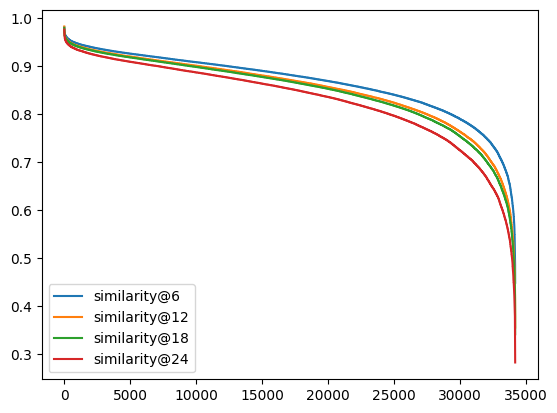

In [40]:
for n in n_values:
    col_name = f'similarity@{n}'
    arr = df_clip[col_name].values
    arr.sort()
    plt.plot(arr[::-1], label=col_name)
plt.legend()
plt.show()

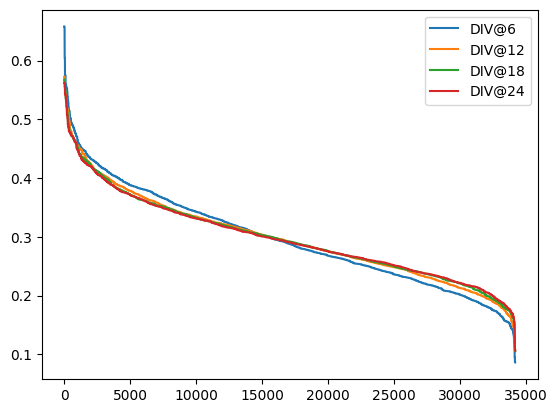

In [41]:
#arr = df_clip['DIV@12'].values
#arr.sort()
#plt.plot(arr[::-1]) # hmm

for n in n_values:
    col_name = f'DIV@{n}'
    arr = df_clip[col_name].values
    arr.sort()
    plt.plot(arr[::-1], label=col_name)
plt.legend()
plt.show()
# hmm...

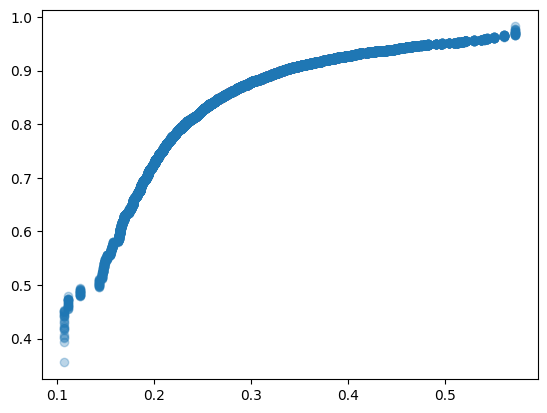

In [43]:
plt.scatter(df_clip['DIV@12'], df_clip['similarity@12'], alpha=0.3)
#plt.scatter(df_clip['DIV@24'], df_clip['similarity@24'], alpha=0.3)
plt.show()

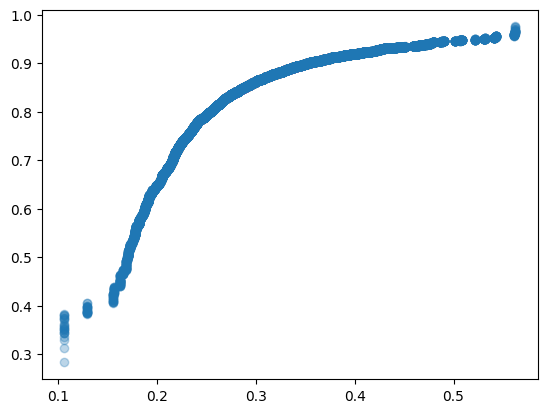

In [42]:
#plt.scatter(df_clip['DIV@12'], df_clip['similarity@12'], alpha=0.3)
plt.scatter(df_clip['DIV@24'], df_clip['similarity@24'], alpha=0.3)
plt.show()

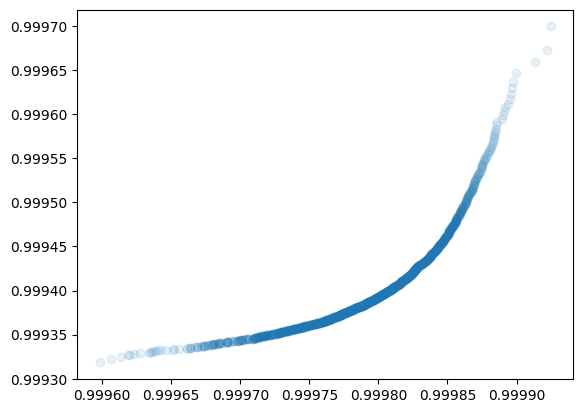

In [44]:
#q_div = 1 - df_clip['DIV@12'].rank() / len(df_clip)
#q_sim = df_clip['similarity@12'].rank() / len(df_clip)
#plt.scatter(q_div, q_sim, alpha=0.1) # uh, yikes?
df_names_grouped = df_clip.groupby('name')
q_div = 1 - df_names_grouped['DIV@12'].mean() / len(df_names_grouped)
q_sim = 1-df_names_grouped['similarity@12'].mean() / len(df_names_grouped)
plt.scatter(q_div, q_sim, alpha=0.1)

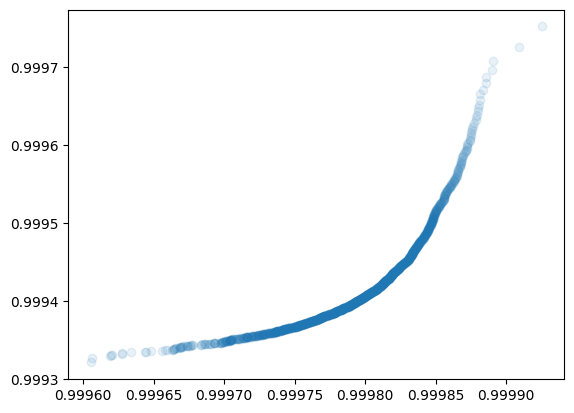

In [45]:
#q_div = 1 - df_clip['DIV@12'].rank() / len(df_clip)
#q_sim = df_clip['similarity@12'].rank() / len(df_clip)
#plt.scatter(q_div, q_sim, alpha=0.1) # uh, yikes?
df_names_grouped = df_clip.groupby('name')
q_div = 1 - df_names_grouped['DIV@24'].mean() / len(df_names_grouped)
q_sim = 1-df_names_grouped['similarity@24'].mean() / len(df_names_grouped)
plt.scatter(q_div, q_sim, alpha=0.1)

In [46]:
df_names_ranked_div = df_clip.groupby('name')['DIV@24'].mean().sort_values(ascending=False)

In [47]:
df_names_ranked_div.head(50)

name
Picabo Street           0.562324
Bradley Cooper          0.560949
Siti Badriah            0.543127
H.E.R.                  0.541804
Toše Proeski            0.541129
Martin Scorsese         0.531330
Ayim Mukhamedjanova     0.530510
Takeshi Kaneshiro       0.521283
Diana Hayden            0.508052
Kathem Al-Saher         0.506452
Nikhil Advani           0.501705
Jason Bateman           0.490589
Ricky Schroder          0.487858
Cicely Tyson            0.485854
Tim Robbins             0.480424
Diya Mirza              0.479414
Joseph Gordon-Levitt    0.478455
Cote de Pablo           0.478105
Chen Daoming            0.478038
Ronaldinho              0.476238
Shirley MacLaine        0.475861
Tom Hardy               0.473240
Yalitza Aparicio        0.472564
Hu Ge                   0.472149
Yassi Pressman          0.472068
Ranbir Kapoor           0.471658
Simone Manuel           0.470536
Ayesha Takia            0.470337
Ian Somerhalder         0.469456
Salman Ahmad            0.467348
Rosie

In [48]:
df_names_ranked_div.tail(50)

name
Taye Diggs              0.190835
Jorge Negrete           0.190817
Taraji P                0.190736
Luis Suárez             0.189651
Ji Chang-wook           0.189456
Han Hyo-joo             0.188920
Jo In-sung              0.188787
Ana Ivanović            0.188375
Dia Mirza               0.187797
Sushant Singh Rajput    0.187792
Ali Fazal               0.187694
Lee Chong Wei           0.187240
Ella Aminuddin          0.187067
Amber Liu               0.187033
Hima Das                0.185978
Jana Burčeska           0.185647
Shakira                 0.184560
Morgan Freeman          0.184218
Sung Kang               0.183442
Edwin Moses             0.183085
Christina Ricci         0.182262
Kunal Nayyar            0.181745
Manny Pacquiao          0.181596
Izara Aishah            0.181472
Will Pan                0.180472
Bong Joon-ho            0.178996
Haruma Miura            0.178738
Aidana Medenova         0.178517
Whitney Houston         0.177750
Lou Diamond Phillips    0.177595
Nicol

In [44]:
# q=.1
# thresholded_scores = Counter()
# for name, df_name in df_clip.groupby('name'):
#     thresh = df_name['similarity@12'].quantile(q)
#     df_q = df_name[df_name['similarity@12'] > thresh]
#     thresholded_scores[name] = df_q['similarity@12'].mean()
#     # oh right, need to recompute centroid after dropping the bad records. ugh.
# df_thresholded = pd.Series(thresholded_scores).sort_values(ascending=False)
# for i, (name, value) in enumerate(df_thresholded.items()):
#     print(f"{i}\t{value:.2f}\t{name}")

In [52]:
df_names_ranked_sim = df_clip.groupby('name')['similarity@24'].mean().sort_values(ascending=False)
#df_names_ranked[df_names_ranked>.8]
#for rank, (name, score) in enumerate(df_names_ranked.items()):
#    print(f"{rank}\t{score}\t{name}")

In [55]:
df_names_ranked_sim.head(50)

name
Picabo Street           0.967000
Bradley Cooper          0.958883
Siti Badriah            0.955912
H.E.R.                  0.954081
Toše Proeski            0.952474
Martin Scorsese         0.951192
Ayim Mukhamedjanova     0.949829
Takeshi Kaneshiro       0.948751
Diana Hayden            0.947998
Kathem Al-Saher         0.947266
Nikhil Advani           0.946411
Jason Bateman           0.945780
Ricky Schroder          0.945048
Cicely Tyson            0.944519
Tim Robbins             0.943868
Diya Mirza              0.943380
Joseph Gordon-Levitt    0.942790
Cote de Pablo           0.942118
Chen Daoming            0.941752
Ronaldinho              0.941142
Shirley MacLaine        0.940715
Tom Hardy               0.940267
Yalitza Aparicio        0.939819
Hu Ge                   0.939453
Yassi Pressman          0.939148
Ranbir Kapoor           0.938822
Simone Manuel           0.938456
Ayesha Takia            0.937988
Ian Somerhalder         0.937785
Salman Ahmad            0.937500
Rosie

In [56]:
df_names_ranked_sim.tail(50)

name
Taye Diggs              0.617798
Jorge Negrete           0.615417
Taraji P                0.613892
Luis Suárez             0.611755
Ji Chang-wook           0.609701
Han Hyo-joo             0.607992
Jo In-sung              0.606303
Ana Ivanović            0.604350
Dia Mirza               0.602498
Sushant Singh Rajput    0.600769
Ali Fazal               0.598816
Lee Chong Wei           0.596700
Ella Aminuddin          0.594767
Amber Liu               0.592672
Hima Das                0.590820
Jana Burčeska           0.588338
Shakira                 0.585470
Morgan Freeman          0.583313
Sung Kang               0.581360
Edwin Moses             0.579305
Christina Ricci         0.577047
Kunal Nayyar            0.574259
Manny Pacquiao          0.571187
Izara Aishah            0.568827
Will Pan                0.566345
Bong Joon-ho            0.563232
Haruma Miura            0.560221
Aidana Medenova         0.557088
Whitney Houston         0.554057
Lou Diamond Phillips    0.550293
Nicol

<Axes: xlabel='name'>

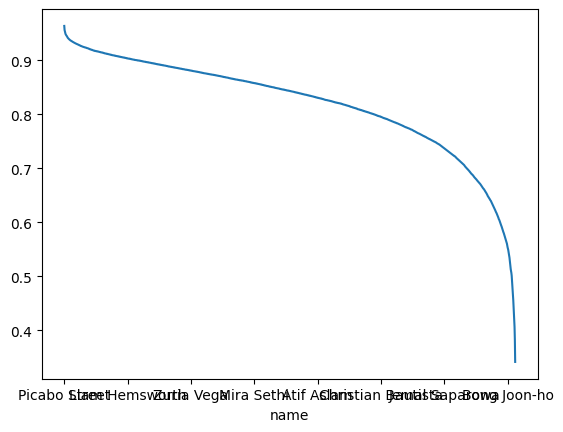

In [72]:
df_names_ranked = df_clip.groupby('name')['similarity@12'].mean().sort_values(ascending=False)
#df_names_ranked[df_names_ranked>.8]
#for rank, (name, score) in enumerate(df_names_ranked.items()):
#    print(f"{rank}\t{score}\t{name}")
df_names_ranked.plot()

In [49]:
for rank, (name, score) in enumerate(df_names_ranked.items()):
    print(f"{rank}\t{score:.3f}\t{name}")

0	0.964	Picabo Street
1	0.956	Bradley Cooper
2	0.954	Siti Badriah
3	0.951	H.E.R.
4	0.949	Toše Proeski
5	0.948	Martin Scorsese
6	0.947	Ayim Mukhamedjanova
7	0.946	Takeshi Kaneshiro
8	0.945	Diana Hayden
9	0.944	Kathem Al-Saher
10	0.943	Nikhil Advani
11	0.942	Jason Bateman
12	0.941	Ricky Schroder
13	0.940	Cicely Tyson
14	0.940	Tim Robbins
15	0.939	Diya Mirza
16	0.939	Joseph Gordon-Levitt
17	0.938	Cote de Pablo
18	0.938	Chen Daoming
19	0.937	Ronaldinho
20	0.937	Shirley MacLaine
21	0.937	Tom Hardy
22	0.936	Yalitza Aparicio
23	0.936	Hu Ge
24	0.935	Yassi Pressman
25	0.935	Ranbir Kapoor
26	0.935	Simone Manuel
27	0.934	Ayesha Takia
28	0.934	Ian Somerhalder
29	0.934	Salman Ahmad
30	0.933	Rosie Perez
31	0.933	Sandhya Mridul
32	0.933	Marilyn Monroe
33	0.932	Kirsten Dunst
34	0.932	Allu Arjun
35	0.932	Antonio Aguilar
36	0.931	Zhou Xun
37	0.931	Sebastian Castro
38	0.931	Yoo Jae-suk
39	0.931	Gauhar Khan
40	0.930	Anil Kapoor
41	0.930	Sara Ali Khan
42	0.930	Miranada Ayim
43	0.930	Meryl Streep
44	0.929	S

In [57]:
df_clip.shape

(34200, 16)

In [58]:
df_clip.columns

Index(['class_idx', 'name', 'root', 'image_id', 'embed_type', 'path', 'embed',
       'embed_normed', 'similarity@6', 'DIV@6', 'similarity@12', 'DIV@12',
       'similarity@18', 'DIV@18', 'similarity@24', 'DIV@24'],
      dtype='object')

In [59]:
df_names_ranked_sim.to_csv('2023-10-03_names_ranked_sim.gpt-diversity.csv')
df_names_ranked_div.to_csv('2023-10-03_names_ranked_div.gpt-diversity.csv')

In [60]:
#np.array(df_embeds['embed_normed']).shape
#df_embeds.shape
classes = np.array([class_idx for class_idx in df_embeds['class_idx']])
embeds = np.array([emb.ravel() for emb in df_embeds['embed_normed']])
embeds.shape # (34200, 512)


(34200, 512)

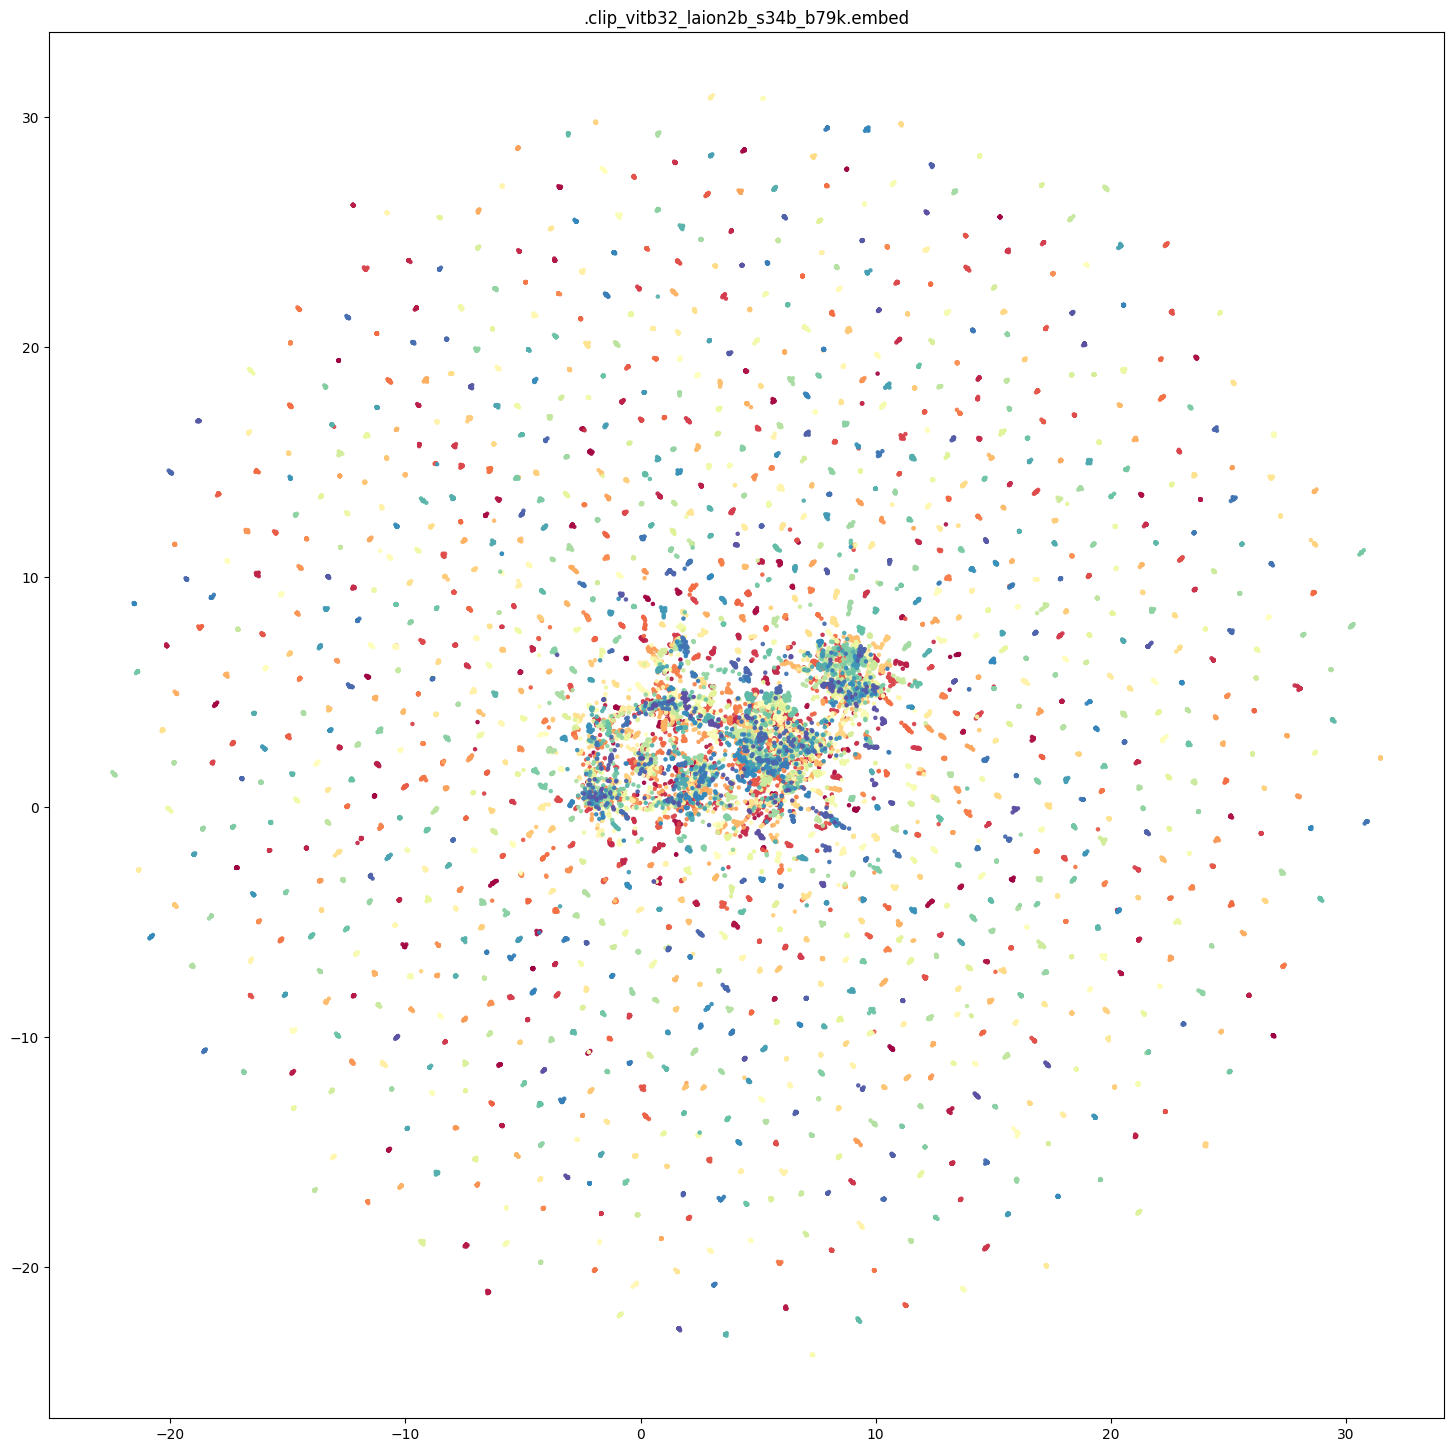

CPU times: user 36min 36s, sys: 33min 37s, total: 1h 10min 13s
Wall time: 5min 47s


In [61]:
%%time

# SUPERVISED UMAP

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=64, #20,
    #min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
#umap_embeds = umap_model.fit_transform(df_embeds['embed_normed'], y=df_embeds['name'])
umap_embeds = umap_model.fit_transform(embeds, classes)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title(f"{emb_suffix}")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("umap-supervised_gpt-celebs_24.png")

plt.show()
# WAAAAAY better

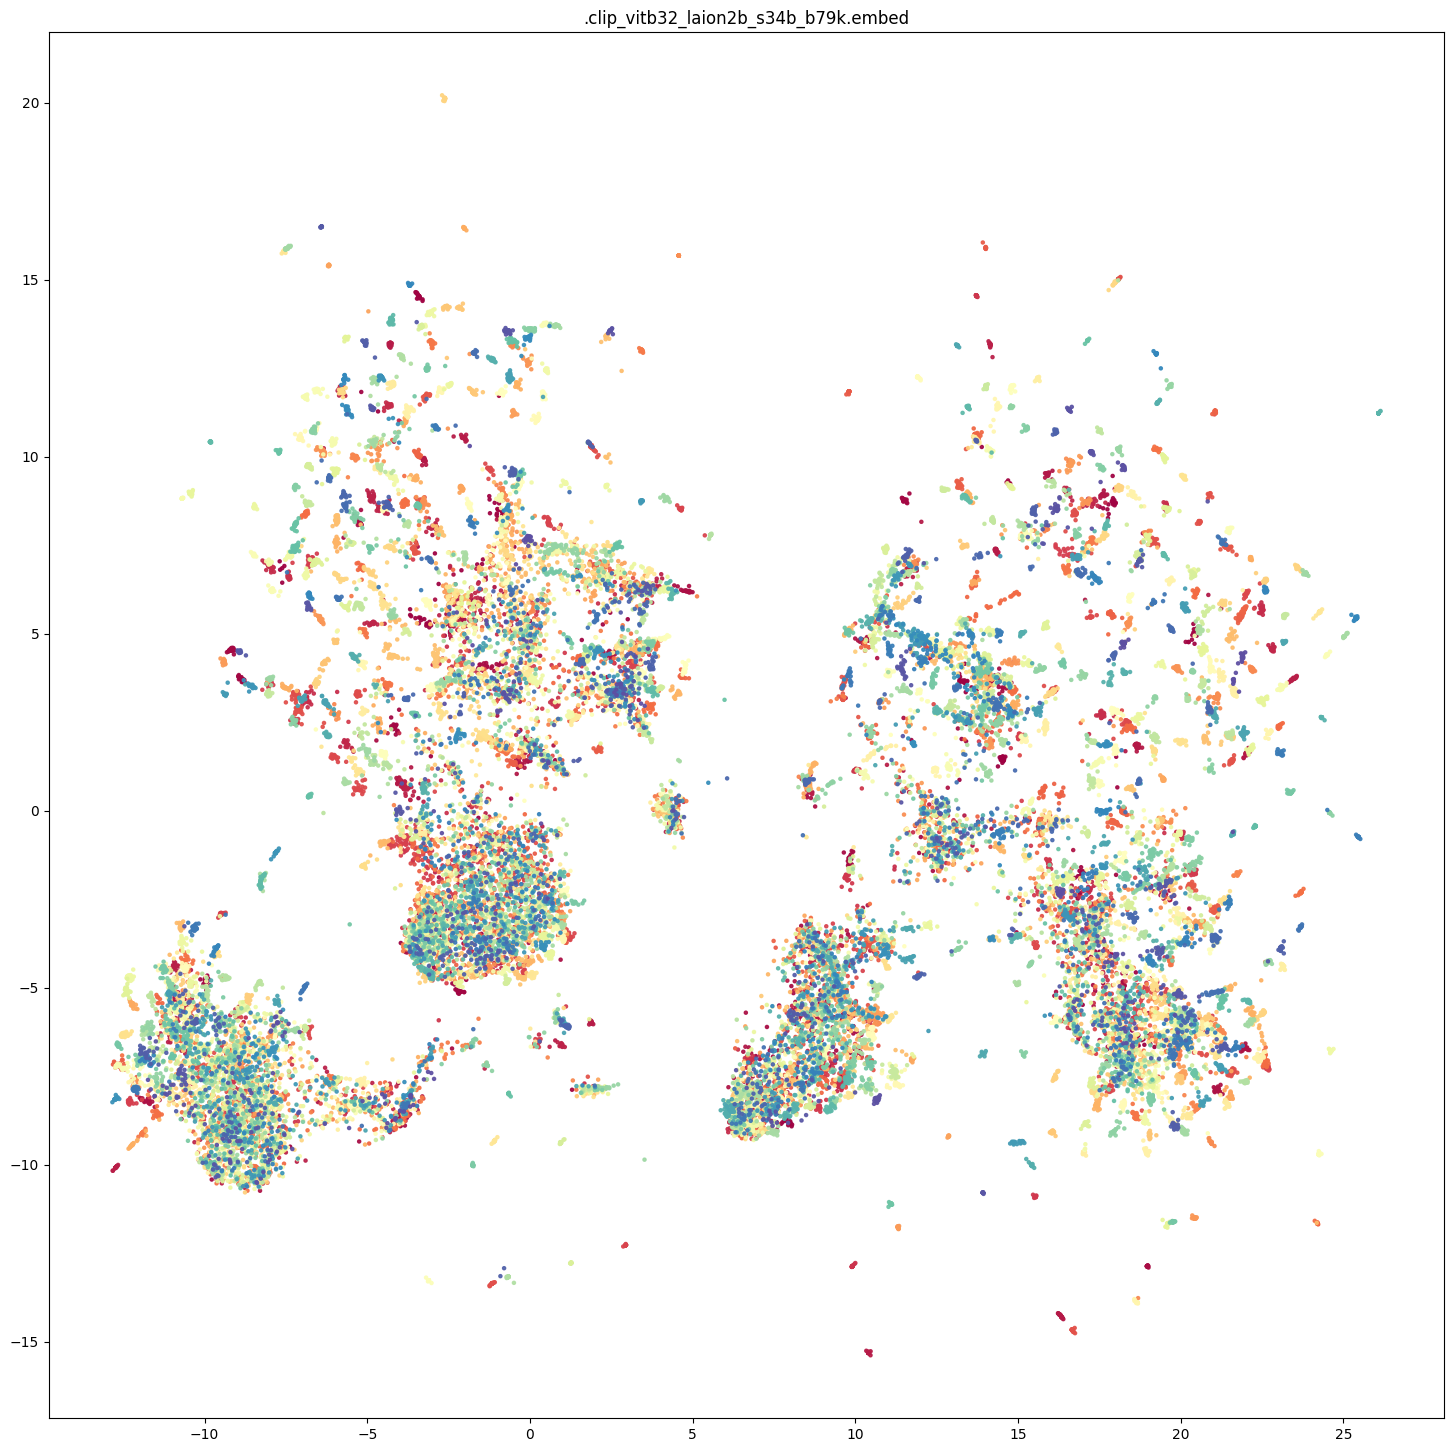

CPU times: user 14min 46s, sys: 22 s, total: 15min 8s
Wall time: 58.5 s


In [63]:
%%time

# unsupervised umap

# vits

import umap

umap_model = umap.UMAP(
    n_neighbors=64, #20,
    #min_dist=.001,
    init='spectral',
    n_epochs=100,
    #local_connectivity=2,
    negative_sample_rate=20,
    repulsion_strength=1.5,
    #spread =1,
)
#umap_embeds = umap_model.fit_transform(df_embeds['embed_normed'], y=df_embeds['name'])
#umap_embeds = umap_model.fit_transform(embeds, classes)
umap_embeds = umap_model.fit_transform(embeds)

plt.scatter(
    *umap_embeds.T,
    s=5, 
    c=classes,
    cmap='Spectral',
    alpha=.9)
plt.title(f"{emb_suffix}")

fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.savefig("umap-unsupervised_gpt-celebs_24.png")

plt.show()
# WAAAAAY better

In [79]:
embeds.shape

(17100, 512)

In [1]:
!which python

/home/dmarx/_venv/bin/python


In [3]:
#%pip install emblaze
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


In [64]:
import emblaze
from emblaze.utils import Field, ProjectionTechnique

In [65]:
classes = np.array([class_idx for class_idx in df_embeds['class_idx']])
embeds = np.array([emb.ravel() for emb in df_embeds['embed_normed']])
embeds.shape # (17100, 512)

(34200, 512)

In [66]:
import emblaze
from emblaze.utils import Field, ProjectionTechnique
from emblaze.thumbnails import TextThumbnails


# X is an n x k array, Y is a length-n array
X, Y = embeds, classes
annotations = TextThumbnails(df_embeds['name'], descriptions=None, ids=None)


# Represent the high-dimensional embedding
emb = emblaze.Embedding({Field.POSITION: X, Field.COLOR: Y})
# Compute nearest neighbors in the high-D space (for display)
emb.compute_neighbors(metric='cosine')

# Generate UMAP 2D representations - you can pass UMAP parameters to project()
variants = emblaze.EmbeddingSet([
    emb.project(method=ProjectionTechnique.UMAP) for _ in range(10)
])
# Compute neighbors again (to indicate that we want to compare projections)
#variants.compute_neighbors(metric='euclidean')

# oh maybe i just need to call this with a `file` argument and it'll write it to a file?
w = emblaze.Viewer(embeddings=variants, thumbnails=annotations)
w

/home/dmarx/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Viewer(colorScheme='plasma', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 34200, 'ids'…

In [70]:
#with open("emblaze-atlas_gpt-names1425_clipb32.json", 'wb') as f:
#    w.save_comparison(f) 
#dir(w)
dir(emblaze.Viewer)

['__annotations__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_active_widgets',
 '_add_notifiers',
 '_all_trait_default_generators',
 '_call_widget_constructed',
 '_comm_changed',
 '_compare',
 '_compute_selection_order',
 '_control_comm',
 '_defaultFrameColors',
 '_default_keys',
 '_descriptors',
 '_dom_classes',
 '_gen_repr_from_keys',
 '_get_embed_state',
 '_get_filter_points',
 '_get_trait_default_generator',
 '_handle_control_comm_msg',
 '_handle_custom_msg',
 '_handle_msg',
 '_holding_sync',
 '_instance_inits',
 '_is_numpy',
 '_lock_property',
 '_log_default',
 '_model_module',
 '_model_module_version',
 '_mode

In [21]:
#dir(emblaze.viewer)
#dir(emblaze.utils)
emblaze._version.__version__ #version_info

'0.9.4'

In [23]:
emblaze.viewer.Viewer.save_comparison

AttributeError: type object 'Viewer' has no attribute 'save_comparison'